# Data Analysis for Nandos

In [31]:
#imports and functions
import pandas as pd
import os, math
import itertools
from itertools import combinations, chain
import numpy as np 
from functools import lru_cache
import itertools, warnings, pathlib, sys
import re


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.patches as patches


from sklearn import preprocessing
from scipy import stats
from scipy.stats import ttest_ind, f_oneway, ttest_rel
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import pingouin as pg
from statsmodels.formula.api import mixedlm
import scipy.stats as ss
import statsmodels.stats.sandwich_covariance as sw

plt.rcParams['font.family'] = "Century Gothic"
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 10})

def analyze_drinks_periods(df_wide, input_drinks, input_periods, metric):
    """
    Analyzes heart rate data for selected drinks and periods.
    
    Parameters:
      df_wide (pd.DataFrame): Wide-format DataFrame created from your original data,
                              with one row per subject and columns named like "A_os_ECG_..."
      input_drinks (list of str): List of drink codes to include (e.g., ['A', 'B'] or ['A', 'D']).
      input_periods (list of str): List of period names (exactly matching the suffixes in the columns)
                                   in chronological order.
      metric (str): Mettric used in analysis
                                   
    Returns:
      Model result and/or test statistics along with post-hoc comparisons (including p-values and Cohen's d).
    """
    # Define which drinks belong to which group:
    group1 = set(['A', 'B', 'C'])
    group2 = set(['D', 'E', 'F'])
    group3 = set(['G', 'H', 'I'])
    
    # Check if all selected drinks are in one group:
    input_drink_set = set(input_drinks)
    if input_drink_set.issubset(group1) or input_drink_set.issubset(group2) or input_drink_set.issubset(group3):
        same_group = True
    else:
        same_group = False

    # Single period vs. multiple periods?
    multiple_periods = len(input_periods) > 1

    # Build the list of column names for the cross-product of selected drinks and periods.
    # (For example: "A_os_ECG_CPT_Baseline_E1.0_MeanHR")
    subset_cols = []
    for drink in input_drinks:
        for period in input_periods:
            colname = f"{drink}_{period}"
            if colname in df_wide.columns:
                subset_cols.append(colname)
            else:
                print(f"Warning: Column {colname} not found in the DataFrame.")
    
    # Create a DataFrame subset including the subject identifier "Number" and the desired columns.
    df_sub = df_wide[['Number'] + subset_cols].copy()
    
    # Reshape from wide to long format.
    df_long = pd.melt(df_sub, id_vars=['Number'], var_name='Condition', value_name=metric)
    
    # Drop rows with missing MeanHR.
    df_long = df_long.dropna(subset=[metric])
    
    # Split 'Condition' into 'Drink' and 'Period'
    df_long['Drink'] = df_long['Condition'].apply(lambda x: x.split('_')[0])
    df_long['Period'] = df_long['Condition'].apply(lambda x: '_'.join(x.split('_')[1:]))
    # Set Period as a categorical variable with the order provided.
    df_long['Period'] = pd.Categorical(df_long['Period'], categories=input_periods, ordered=True)
    
    if same_group and multiple_periods:
        # Within-subject design: both Drink and Period are repeated.
        # Determine the expected number of conditions per subject:
        expected_conditions = len(input_drinks) * len(input_periods)
        print(f"Expected conditions per subject: {expected_conditions}")
        
        # Filter subjects: only include subjects with a complete set of measurements.
        df_balanced = df_long.groupby("Number").filter(lambda x: len(x) == expected_conditions)
        num_subjects = df_balanced["Number"].nunique()
        print("Number of subjects after filtering for balanced data:", num_subjects)
        
        try:
            aovrm = AnovaRM(data=df_balanced, depvar=metric, subject='Number', within=['Drink', 'Period'])
            res = aovrm.fit()
            print("\nANOVA Results:\n")
            print(res)
            
            print("\nPost-hoc pairwise comparisons for Drink:")
            posthoc_drink = pg.pairwise_tests(data=df_balanced, dv=metric, within='Drink', subject='Number',
                                            padjust='bonf', effsize='cohen')
            print(posthoc_drink)
            
            print("\nPost-hoc pairwise comparisons for Period:")
            posthoc_period = pg.pairwise_tests(data=df_balanced, dv=metric, within='Period', subject='Number',
                                            padjust='bonf', effsize='cohen')
            print(posthoc_period)
            output = {'anova': res, 'posthoc_drink': posthoc_drink, 'posthoc_period': posthoc_period}
            return output

        except Exception as e:
            print("Error running repeated measures ANOVA:", e)
            return None

    elif same_group and not multiple_periods:
        # For a single period in a within-group (paired t-test).
        print("\nRunning paired t-test for a single period within one group...")
        if len(input_drinks) != 2:
            print("Paired t-test requires exactly 2 drinks.")
            return None
        # Build the column names for the two drinks
        d1 = f"{input_drinks[0]}_{input_periods[0]}"
        d2 = f"{input_drinks[1]}_{input_periods[0]}"
        df_pair = df_wide[['Number', d1, d2]].dropna()
        t_stat, p_val = ttest_rel(df_pair[d1], df_pair[d2])
        # Compute Cohen's d for paired samples:
        def cohens_d(x, y):
            diff = x - y
            return diff.mean() / diff.std(ddof=1)
        d_val = cohens_d(df_pair[d1], df_pair[d2])
        print(f"\nPaired t-test results: t = {t_stat:.4f}, p = {p_val:.4f}, Cohen's d = {d_val:.4f}")
        return {'ttest': (t_stat, p_val), 'd': d_val}

    elif (not same_group) and multiple_periods:
        # Mixed design: Drink is a between-subject factor, Period is within.
        print("\nRunning mixed-effects model (Drink as between, Period as within)...")
        # For mixed-effects, add a subject group variable.
        def assign_group(drink):
            if drink in group1:
                return "Group1"
            elif drink in group2:
                return "Group2"
            else:
                return np.nan
        subject_group = df_long.groupby('Number')['Drink'].first().reset_index()
        subject_group['SubjectGroup'] = subject_group['Drink'].apply(assign_group)
        df_long = df_long.merge(subject_group[['Number', 'SubjectGroup']], on='Number', how='left')
        
        # Fit a mixed-effects model with a random intercept for subjects.
        formula = f"{metric} ~ Drink * Period"
        try:
            model = smf.mixedlm(formula, df_long, groups=df_long["Number"])
            mixed_result = model.fit()
            print("\nMixed-effects model results:\n")
            print(mixed_result.summary())
            
            # Post-hoc comparisons for the within factor (Period) using pingouin.
            print("\nPost-hoc pairwise comparisons for Period (Mixed design):")
            posthoc_period = pg.pairwise_tests(data=df_long, dv=metric, within='Period', subject='Number',
                                               padjust='bonf', effsize='cohen')
            print(posthoc_period)
            return {'mixed_model': mixed_result, 'posthoc_period': posthoc_period}
        except Exception as e:
            print("Error in mixed-effects model:", e)
            return None

    elif (not same_group) and not multiple_periods:
        # Independent samples t-test: comparing a single period between two groups.
        print("\nRunning independent samples t-test for a single period (between groups)...")
        if len(input_drinks) != 2:
            print("Independent samples t-test requires exactly 2 drinks.")
            return None
        d1 = f"{input_drinks[0]}_{input_periods[0]}"
        d2 = f"{input_drinks[1]}_{input_periods[0]}"
        df_ind = df_wide[['Number', d1, d2]].dropna()
        t_stat, p_val = ttest_ind(df_ind[d1], df_ind[d2])
        # Compute Cohen's d for independent samples:
        def cohens_d_ind(x, y):
            nx, ny = len(x), len(y)
            dof = nx + ny - 2
            pooled_std = np.sqrt(((nx - 1)*x.std(ddof=1)**2 + (ny - 1)*y.std(ddof=1)**2) / dof)
            return (x.mean() - y.mean()) / pooled_std
        d_val = cohens_d_ind(df_ind[d1], df_ind[d2])
        print(f"\nIndependent samples t-test results: t = {t_stat:.4f}, p = {p_val:.4f}, Cohen's d = {d_val:.4f}")
        return {'ttest_ind': (t_stat, p_val), 'd': d_val}

    else:
        print("Unhandled design case.")
        return None



def fmt_p(p: float) -> str:
    """Return '<0.001' or a rounded string with 3 decimals."""
    return "<0.001" if p < 0.001 else f"{p:.3f}"

def format_simpletable_p(table, p_col=4):
    # skip header row -> table.data[1:]
    for row in table.data[1:]:
        row[p_col] = fmt_p(float(row[p_col]))

def format_pvals(tbl, *, col='p-value', col_idx=4):
    """
    Format p-values in either a pandas DataFrame or a statsmodels SimpleTable.
    """
    if isinstance(tbl, pd.DataFrame):
        tbl[col] = tbl[col].apply(fmt_p)
        return tbl
    # SimpleTable
    for row in tbl.data[1:]:
        row[col_idx] = fmt_p(float(row[col_idx]))
    return tbl

def safe_fit(mixed_model):
    """LBFGS → Powell → drop-zero-variance fallback."""
    try:
        return mixed_model.fit(method="lbfgs", maxiter=200, disp=False)
    except Exception as e1:
        print("  LBFGS failed – trying Powell …", str(e1))
        try:
            return mixed_model.fit(method="powell", maxiter=300, disp=False)
        except Exception as e2:
            print("  Powell failed – dropping 0-var columns …", str(e2))
            keep = mixed_model.exog.var(0) > 0
            mixed_model.exog = mixed_model.exog[:, keep]
            mixed_model.exog_names = [n for k,n in zip(keep, mixed_model.exog_names) if k]
            return mixed_model.fit(method="powell", maxiter=300, disp=False)
        
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    s_p    = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / (nx+ny-2))
    return (x.mean() - y.mean()) / s_p

def drop_outliers(df: pd.DataFrame, col: str, *, multiplier: float = 1.5) -> pd.DataFrame:
    """
    Return a *copy* of `df` with every row removed whose value in `col`
    lies outside the IQR×multiplier range.

    Parameters
    ----------
    df : pd.DataFrame
    col : str
        Column on which to compute the IQR fence.
    multiplier : float, default 1.5
        Tukey fence width (1.5 → “mild” outliers, 3 → “extreme” outliers).

    Returns
    -------
    pd.DataFrame
        New DataFrame with outlier rows dropped.
    """
    q1  = df[col].quantile(0.25)
    q3  = df[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
    keep_mask = df[col].between(lower, upper)

    # .loc keeps the original index values; .reset_index(drop=True) if you prefer fresh 0-based.
    return df.loc[keep_mask].copy()

In [114]:
# New functions

def tukey_filter(x, k=1.5):
    """Return array with points outside [Q1-k·IQR, Q3+k·IQR] removed."""
    x = x[~np.isnan(x)]
    if x.size < 4:                      # don't decimate tiny samples
        return x
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return x[(x >= lo) & (x <= hi)]

# ── MAIN PLOTTING FUNCTION ────────────────────────────────
def plot_repeated_measures(df, grouping_col, periods: dict, y_label="",title=""):

    groups        = sorted(df[grouping_col].dropna().unique())
    n_groups      = len(groups)
    x_pos         = np.arange(len(periods))          # 0,1,2,...
    width         = 0.8 / n_groups
    dodge         = {g: (-0.4 + i*width + width/2) for i, g in enumerate(groups)}

    fig, ax = plt.subplots(figsize=(4, 2))

    for g in groups:
        rows = df[df[grouping_col] == g]

        data_arrays = []
        for col in periods.keys():
            arr = tukey_filter(rows[col].to_numpy(dtype=float))
            if arr.size == 0:
                print(f"⚠️  empty after filtering → group {g}, period '{col}'")
                arr = np.array([np.nan])             # placeholder so positions stay aligned
            data_arrays.append(arr)

        pos = x_pos + dodge[g]

        bp = ax.boxplot(
            data_arrays,
            positions=pos,
            widths=width,
            showfliers=False,
            patch_artist=True,
            manage_ticks=False,
        )

        # colours
        for box in bp["boxes"]:
            box.set(facecolor=color_palette[g], edgecolor=color_palette[g], alpha=0.6)
        for part in ["whiskers", "caps"]:
            for item in bp[part]:
                item.set(color=color_palette[g])
        for med in bp["medians"]:
            med.set(color="black", linewidth=1.5)

        # # means
        # means = [np.nanmean(a) for a in data_arrays]
        # ax.plot(
        #     pos, means,
        #     marker="o", linestyle="-", linewidth=1,
        #     color=line_colors.get(g, color_palette[g]),
        #     zorder=3
        # )

    # axes & legend
    ax.set_xticks(x_pos)
    ax.set_xticklabels(list(periods.values()), fontsize=9)
    ax.set_ylabel(y_label, fontsize=12)

    handles = [patches.Patch(facecolor=color_palette[g], label=subset_dict[g]) for g in groups]
    ax.legend(handles=handles, title="Group", frameon=False)
    
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.grid(False)
    
    ax.legend()
    ax.get_legend().remove() 
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_std(df, grouping_col, periods: dict, title="", y_label="Average SD"):
    """
    For each group, at each period:
        SD = std( values_group_period  −  mean_allGroups_period )
    Then average those SDs across periods → one number per group.

    Arguments
    ---------
    df            : pandas.DataFrame
    grouping_col  : str       – column with group codes (must match subset_dict keys)
    periods       : dict      – ordered {column_header: pretty_label}
    title         : str       – plot title
    y_label       : str       – y-axis label (default 'Average SD')
    """
    groups = sorted(df[grouping_col].dropna().unique())
    sd_acc = {g: [] for g in groups}

    # ── loop over periods first so we only compute population mean once per period
    for col in periods.keys():
        # overall mean (NaN-aware, raw values)
        pop_vals  = df[col].to_numpy(dtype=float)
        pop_mean  = np.nanmean(pop_vals)

        # now per-group SD (filtered, relative to pop_mean)
        for g in groups:
            grp_vals = df.loc[df[grouping_col] == g, col].to_numpy(dtype=float)
            grp_vals = tukey_filter(grp_vals)              # remove outliers
            if grp_vals.size > 1:                          # need ≥2 for SD
                sd = np.nanstd(grp_vals - pop_mean, ddof=1)
                sd_acc[g].append(sd)

    # ── average across periods
    avg_sd = {g: np.nanmean(sds) if sds else np.nan for g, sds in sd_acc.items()}

    # ── simple bar plot
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.bar(
        x,
        [avg_sd[g] for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6
    )

    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], rotation=0, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_signed_diff(
    df,
    grouping_col,
    periods: dict,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())
    diff_acc = {g: [] for g in groups}

    for col in periods.keys():
        # population mean (after outlier trim on *whole* column)
        pop_vals = tukey_filter(df[col].to_numpy(dtype=float))
        pop_mean = np.nanmean(pop_vals)

        for g in groups:
            grp_vals = tukey_filter(df.loc[df[grouping_col] == g, col].to_numpy(dtype=float))
            if grp_vals.size:
                grp_mean = np.nanmean(grp_vals)
                diff_acc[g].append(grp_mean - pop_mean)

    avg_diff = {g: np.nanmean(v) if v else np.nan for g, v in diff_acc.items()}

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [avg_diff[g] for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_mean(
    df,
    grouping_col,
    periods: dict,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())
    diff_acc = {g: [] for g in groups}

    for col in periods.keys():
        for g in groups:
            grp_vals = tukey_filter(df.loc[df[grouping_col] == g, col].to_numpy(dtype=float))
            if grp_vals.size:
                grp_mean = np.nanmean(grp_vals)
                diff_acc[g].append(grp_mean)

    avg_diff = {g: np.nanmean(v) if v else np.nan for g, v in diff_acc.items()}

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [avg_diff[g] for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_mean_aoi(
    df,
    grouping_col,
    metric,
    periods: dict,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
    color='deepskyblue'
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = periods.keys()
    diff_acc = {g: [] for g in groups}

    for col in periods.keys():
        for g in groups:
            if metric == 'TFD':
                values = df.loc[df[grouping_col] == g][['respondent',col]].groupby('respondent').sum().to_numpy(dtype=float)
            elif metric == 'TTFF':
                values = df.loc[df[grouping_col] == g][['respondent',col]].groupby('respondent').min().to_numpy(dtype=float)
            elif metric == 'FixationCount':
                values = df.loc[df[grouping_col] == g][['respondent',col]].groupby('respondent').sum().to_numpy(dtype=float)
            grp_vals   = tukey_filter(values)
            if grp_vals.size:
                grp_mean = np.nanmean(grp_vals)
                diff_acc[g].append(grp_mean)

    avg_diff = {g: np.nanmean(v) if v else np.nan for g, v in diff_acc.items()}

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))

    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [avg_diff[g] for g in groups],
        color=color,
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=9)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()



def plot_clustered_aoi(
    df,
    grouping_col,           # column that matches the keys in `periods`
    second_grouping_col,    # ← new: second factor (e.g. 'subset')
    metric,
    periods: dict,          # ordered mapping {col_header : pretty_label}
    title="",
    y_label="Mean value",
    colors=None,             # ← dict: {second_group : colour}
    y_lim = False,
    
):
    """
    For every period (x-tick) and every level of `second_grouping_col`:
        mean = mean( df[value_col] | rows with grouping_col == period_key
                                           & second_grouping_col == level )
    Then bar-plot those means, colour-coded by `colors`.
    """

    # levels of the inner factor (bars within each x-tick)
    inner_levels = sorted(df[second_grouping_col].dropna().unique())
    n_inner      = len(inner_levels)

    # default colours if dict not supplied / incomplete
    if colors is None:
        cmap   = plt.cm.get_cmap("tab10")
        colors = {lvl: cmap(i) for i, lvl in enumerate(inner_levels)}
    else:
        missing = [lvl for lvl in inner_levels if lvl not in colors]
        if missing:
            raise ValueError(f"Colour dict missing keys: {missing}")

    # bar positions
    x_ticks = np.arange(len(periods))          # 0,1,2,...
    bar_w   = 0.8 / n_inner                    # cluster width 80 %
    offsets = np.linspace(
        -0.4 + bar_w / 2, 0.4 - bar_w / 2, n_inner
    )                                          # centre the cluster

    # collect means
    means = {lvl: [] for lvl in inner_levels}
    for period_key in periods.keys():
        period_mask = df[grouping_col] == period_key
        for lvl in inner_levels:
            mask   = period_mask & (df[second_grouping_col] == lvl)

            if metric == 'TFD':
                values = df.loc[mask][['respondent',period_key]].groupby('respondent').sum().to_numpy(dtype=float)
                vals   = tukey_filter(values)
            elif metric == 'TTFF':
                values = df.loc[mask][['respondent',period_key]].groupby('respondent').min().to_numpy(dtype=float)
                vals   = tukey_filter(values)
            elif metric == 'FixationCount':
                values = df.loc[mask][['respondent',period_key]].groupby('respondent').sum().to_numpy(dtype=float)
                vals   = tukey_filter(values)
            elif metric == 'Click':
                values = df.loc[mask][['respondent',period_key]].groupby('respondent').sum().to_numpy(dtype=float)
                vals   = values
        
            means[lvl].append(np.nanmean(vals) if vals.size else np.nan)

    # ── PLOT ────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(max(4, len(periods)*1.5), 3))

    for lvl_idx, lvl in enumerate(inner_levels):
        ax.bar(
            x_ticks + offsets[lvl_idx],
            means[lvl],
            width=bar_w,
            color=colors[lvl],
            edgecolor="black",
            label=str(lvl)
        )

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(periods.values()), fontsize=9)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend(title=second_grouping_col, frameon=False, fontsize=9)
    ax.get_legend().remove() 
    if y_lim:
        ax.set_ylim(y_lim)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

In [90]:
# Read in UV
df = pd.read_csv('results/final_uv.csv')
df_idio = pd.read_csv('infiles/df_idio.csv')

df = pd.merge(df,df_idio, on='respondent')

df_r = pd.read_csv('infiles/respondent.csv')
df = pd.merge(df,df_r, on='respondent')

split_variable = 'sm_idiographic_exploration'
#for drink, dfd in df.groupby('Drink'):
df = df.assign(
    # median-split *within each Gate*
    median_split=lambda d: np.where(
        d[split_variable] >
        d.groupby('subset')[split_variable].transform('median'),
        'High Exploration', 'Low Exploration'),

    # quartile-split *within each Gate*
    extreme_split=lambda d: np.select(
        [
            d[split_variable] >= d.groupby('subset')[split_variable]      # top 25 %
                                   .transform(lambda x: x.quantile(0.75)),
            d[split_variable] <= d.groupby('subset')[split_variable]      # bottom 25 %
                                   .transform(lambda x: x.quantile(0.25))
        ],
        ['Extreme High', 'Extreme Low'],
        default=pd.NA)
)

df['split']=df['median_split']

In [86]:
# Basic Info and defines
N = len(df)
print(f'Sample: {N}')

print(f'Columns: {len(df.columns)}')
for c in df.columns:
    print(c)

color_palette = {1:'crimson',
                 2:'darkgray',
                 3:'maroon',}

line_colors = {
    1: "#bb1133",  # darker crimson
    2: "#000000",  # still black – the abyss stares back
    3: "#680000",  # darker maroon
}

# Assuming your groups are labeled 'A', 'B', 'C' in the original "Drink" column
subset_dict = {1:'Current', 2: 'New\nFunctional', 3: 'New\nUnique', }

covariates_to_use = ['PSQI_Overall', 
                    'manual_BodyFat',
                    'Age',
                    'os_Temperature_blankScreen_00_mean',
                    #'psy_Comprehension',
                    #'psy_MAIA_SelfRegulation',
                    #'Saliva_Sampled',
                    #'CPT_Submerge_Duration'
                    #'psy_MAIA_EmotionalAwareness_Score'
                    #'Gender',
                    #'StartTime',
]


Sample: 90
Columns: 157
Unnamed: 0.1
Unnamed: 0
respondent
resp_id_old
subset
subset_old
survey_immediate_start
sns_filename_x
sns_findSpecific_Item1_RT
sns_findSpecific_Item1_AOISelected
sns_findSpecific_Item1_AOIAccuracy
sns_findSpecific_Item1_FixationCount
sns_findSpecific_Item2_RT
sns_findSpecific_Item2_AOISelected
sns_findSpecific_Item2_AOIAccuracy
sns_findSpecific_Item2_FixationCount
sns_findSpecific_Item3_RT
sns_findSpecific_Item3_AOISelected
sns_findSpecific_Item3_AOIAccuracy
sns_findSpecific_Item3_FixationCount
sns_findSpecific_Item4_RT
sns_findSpecific_Item4_AOISelected
sns_findSpecific_Item4_AOIAccuracy
sns_findSpecific_Item4_FixationCount
sns_findSpecific_Item5_RT
sns_findSpecific_Item5_AOISelected
sns_findSpecific_Item5_AOIAccuracy
sns_findSpecific_Item5_FixationCount
sns_findSpecific_Item1_subjUndiscovered
sns_findSpecific_Item2_subjUndiscovered
sns_findSpecific_Item3_subjUndiscovered
sns_findSpecific_Item4_subjUndiscovered
sns_findSpecific_Item5_subjUndiscovered
sns_find

In [35]:
_ = [print(c) for c in df.columns if ('verwhe' in c)]

sm_idiographic_exploration
One-way ANOVA results for sm_idiographic_exploration:
  One-way ANOVA: F(2, 83) = 3.2998, p = 0.0418, η² = 0.0737



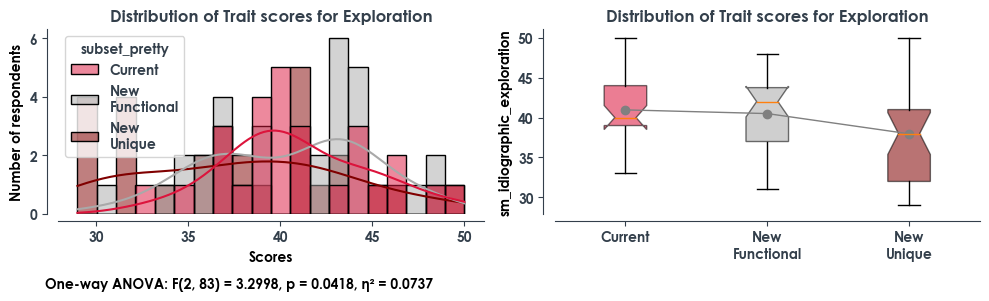

In [36]:
# Plot column data
# =============================================================================
# Define a grouping variable upfront.
group_var = "subset"  # Change this if needed.

# Define data (df columns) to plot
to_plot = [col for col in df.columns if any(keyword in col 
            for keyword in [
                            #'ECG',
                            #'CPT_Submerge-Duration',
                            'sm_idiographic_exp'
                            ])]

# =============================================================================
# Set global aesthetics (similar to your previous graphs)
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'
plt.rcParams['text.color'] = '#333F4B'
plt.rcParams['font.family'] = "Century Gothic"
plt.rcParams.update({'font.size': 10})


# Figure size configuration
width_in_cm = 18.4
height_in_cm = 13.6
x_mod = 0.384
y_mod = 0.384
plt.rcParams['figure.figsize'] = [width_in_cm * x_mod, height_in_cm * y_mod]


# =============================================================================

for col in to_plot:
    try:
        # Create a temporary DataFrame with the current variable and the grouping variable.
        temp_df = df[[col, group_var]].dropna().copy()
        # Remove outliers from the current variable (using default multiplier=1.5)
        temp_df = drop_outliers(temp_df, col, multiplier=1.5)

        # ①  Add a *new* column that stores the pretty label
        temp_df["subset_pretty"] = temp_df[group_var].map(subset_dict)

        # ②  Build a colour palette keyed by the pretty names
        pretty_palette = {
            subset_dict[g]: color_palette[g]   # <- your colour dict from earlier
            for g in sorted(temp_df[group_var].unique())
        }
            
        # Dynamically determine the unique groups.
        unique_groups = sorted(temp_df[group_var].unique())
        
        palette_list = [color_palette.get(g, "#777777") for g in unique_groups]

        # Build a dictionary to hold the data for each group.
        group_series = {}
        box_data = []
        box_labels = []
        for grp in unique_groups:
            series_grp = temp_df.loc[temp_df[group_var] == grp, col]
            group_series[grp] = series_grp
            box_data.append(series_grp)
            box_labels.append(f"{subset_dict[grp]}")
        
        # ----------------------------------------------------------------------------
        # Create a figure with two subplots: left for the histogram, right for the boxplot.
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        # Transparent backgrounds as desired:
        fig.patch.set_alpha(0)
        ax1.patch.set_alpha(0)
        ax2.patch.set_alpha(0)

        print(col)
        
        # --- Left subplot: Histogram with KDE, colored by the grouping variable.
        sns.histplot(
            data=temp_df,
            x=col,
            kde=True,
            bins=20,
            hue='subset_pretty',
            palette=pretty_palette,
            ax=ax1
        )

        #ax1.set_title(f'{col}\nN={len(temp_df)}')
        ax1.set_title(f'Distribution of Trait scores for Exploration')
        ax1.set_ylabel("Number of respondents")
        ax1.set_xlabel('Scores')
        ax1.tick_params(axis='x', rotation=0)
        
        # --- Right subplot: Boxplot for the groups.
        bp = ax2.boxplot(box_data, patch_artist=True, labels=box_labels, notch=True)
        # Set custom colors for each box:
        for patch, colour in zip(bp['boxes'], palette_list):
            patch.set_facecolor(colour)
            patch.set_alpha(0.55)     # slight transparency
            
        ax2.set_title(f'Distribution of Trait scores for Exploration')
        ax2.set_ylabel(col)
        
        # If there are at least two groups, connect the means of each group.
        if len(unique_groups) >= 2:
            # x positions for boxplot are simply 1, 2, ..., number of groups.
            x_positions_box = np.arange(1, len(unique_groups) + 1)
            # Compute mean for each group.
            mean_values = [np.nanmean(group_series[grp]) for grp in unique_groups]
            # Draw a line connecting the means using the desired style.
            ax2.plot(x_positions_box, mean_values, marker='o', color='grey', linestyle='-', linewidth=1)
        
        # ----------------------------------------------------------------------------
        # Dynamic Statistical Testing:
        # If exactly 2 groups, run an independent samples t-test.
        # If more than 2 groups, run one-way ANOVA.
        stats_text = ""
        if len(unique_groups) == 2:
            t_stat, p_val = ttest_ind(group_series[unique_groups[0]],
                                      group_series[unique_groups[1]],
                                      nan_policy='omit')
            def cohens_d_ind(x, y):
                x_clean = x[~np.isnan(x)]
                y_clean = y[~np.isnan(y)]
                n1, n2 = len(x_clean), len(y_clean)
                pooled_sd = np.sqrt(((n1 - 1) * np.std(x_clean, ddof=1)**2 +
                                     (n2 - 1) * np.std(y_clean, ddof=1)**2) / (n1 + n2 - 2))
                return (np.mean(x_clean) - np.mean(y_clean)) / pooled_sd
            d_val = cohens_d_ind(group_series[unique_groups[0]],
                                 group_series[unique_groups[1]])
            stats_text = (f"Independent samples t-test: t = {t_stat:.4f}, "
                          f"p = {p_val:.4f}, Cohen's d = {d_val:.4f}")
            print(f"Independent samples t-test results for {col}:")
            print(f"  {stats_text}\n")
        elif len(unique_groups) > 2:
            f_stat, p_val = f_oneway(*[group_series[grp] for grp in unique_groups])
            df_between = len(unique_groups) - 1
            df_within = sum(len(group_series[grp]) for grp in unique_groups) - len(unique_groups)
            all_data = np.concatenate([group_series[grp].values for grp in unique_groups])
            grand_mean = np.mean(all_data)
            SS_total = np.sum((all_data - grand_mean)**2)
            SS_between = sum(len(group_series[grp]) * (np.mean(group_series[grp]) - grand_mean)**2 
                             for grp in unique_groups)
            eta_sq = SS_between / SS_total if SS_total > 0 else np.nan
            stats_text = (f"One-way ANOVA: F({df_between}, {df_within}) = {f_stat:.4f}, "
                          f"p = {p_val:.4f}, η² = {eta_sq:.4f}")
            print(f"One-way ANOVA results for {col}:")
            print(f"  {stats_text}\n")
        else:
            stats_text = f"Found {len(unique_groups)} group; insufficient data for test."
            print(f"{col}: {stats_text}\n")
        
        # ----------------------------------------------------------------------------
        # Polish aesthetics for both subplots.
        for ax in (ax1, ax2):
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_position(('outward', 8))
            ax.spines['bottom'].set_position(('outward', 5))
        
        # Add the statistics text to the overall figure, left-aligned below the x-axis.
        fig.text(0.05, 0.01, stats_text, ha='left', va='bottom', fontsize=10, color='black')
        
        plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for text
        plt.show()
        plt.close()
    
    except Exception as e:
        print(f'Failed {col}: {e}')


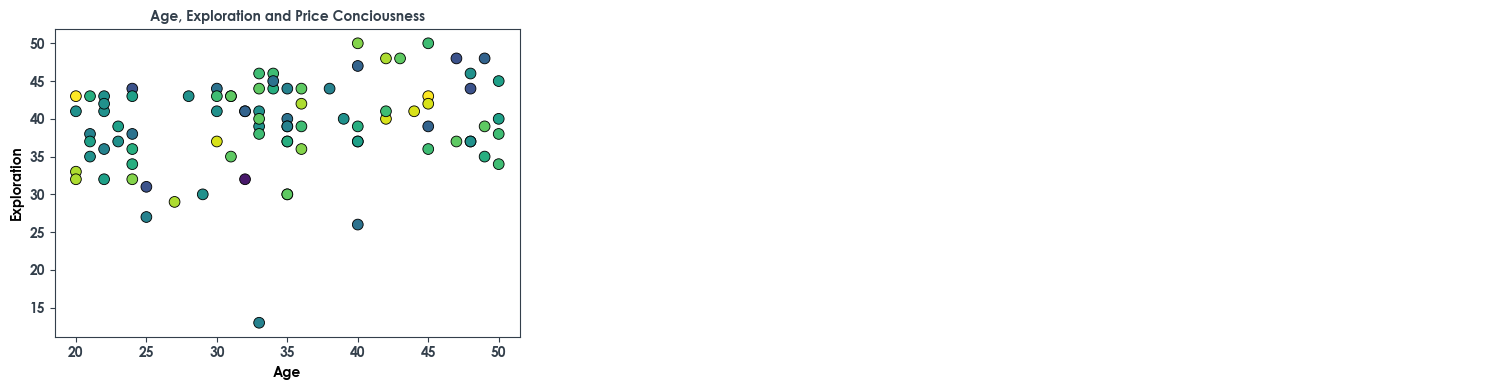

                                 Age  sm_idiographic_exploration
Age                         1.000000                    0.243375
sm_idiographic_exploration  0.243375                    1.000000


In [101]:
# Scatter Plots for Covariates
# ─────────────────────────────────────────────────────────────────────────────

# Prep: make sure the dataframe has no duplicate labels that trip seaborn
# ─────────────────────────────────────────────────────────────────────────────
df = (df                      # use your existing df
        .loc[:, ~df.columns.duplicated()]         # kill duplicate col labels
        .reset_index(drop=True))                  # unique row index

# If StartTime is a datetime, convert to something plottable (optional)
# df['StartTime'] = pd.to_datetime(df['StartTime'], errors='coerce').dt.hour

x_var = 'Age'
#x_var = 'Age'
covariates_to_check = [
                    # 'PSQI_Overall', 
                    # 'manual_BodyFat',
                    #'Age',
                    # 'os_Temperature_blankScreen_00_mean',
                    # 'psy_Comprehension',
                    #'psy_MAIA_SelfRegulation',
                    'sm_idiographic_exploration',
                    'sm_idiographic_priceConsciousness',
                    #'Language'
                    #'Gender',
                    #'StartTime',
]

pairs = list(itertools.combinations(covariates_to_check, 2))
n = len(pairs)
n_cols = 3                       # tweak to taste
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 4 * n_rows),
                         squeeze=False)

for ax, (y_var, hue_var) in zip(axes.flat, pairs):
    sns.scatterplot(
        data=df,
        x=x_var,
        y=y_var,
        hue=hue_var,
        palette='viridis',
        s=60,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f'{y_var} vs {x_var}\n(hue = {hue_var})', fontsize=10)
    ax.set_title(f'Age, Exploration and Price Conciousness', fontsize=10)
    ax.set_xlabel(x_var)
    ax.set_ylabel('Exploration')

    # Keep the legend only on the first subplot to avoid clutter
    if ax is not axes.flat[0]:
        ax.get_legend().remove()
    ax.get_legend().remove()
# Turn off any unused axes if n_pairs isn’t a perfect grid fill
for ax in axes.flat[n:]:
    ax.axis('off')


plt.tight_layout()
plt.show()

print(df[[x_var,y_var]].corr())

In [100]:
print(df[['Age','sm_idiographic_exploration','sm_idiographic_priceConsciousness',]].corr())
print(df[['Age','sm_idiographic_exploration']].min())

                                        Age  sm_idiographic_exploration  \
Age                                1.000000                    0.243375   
sm_idiographic_exploration         0.243375                    1.000000   
sm_idiographic_priceConsciousness  0.028388                    0.061361   

                                   sm_idiographic_priceConsciousness  
Age                                                         0.028388  
sm_idiographic_exploration                                  0.061361  
sm_idiographic_priceConsciousness                           1.000000  
Age                           20.0
sm_idiographic_exploration    13.0
dtype: float64


# Find Specific

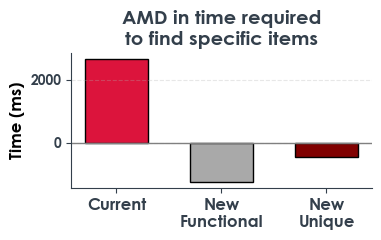

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


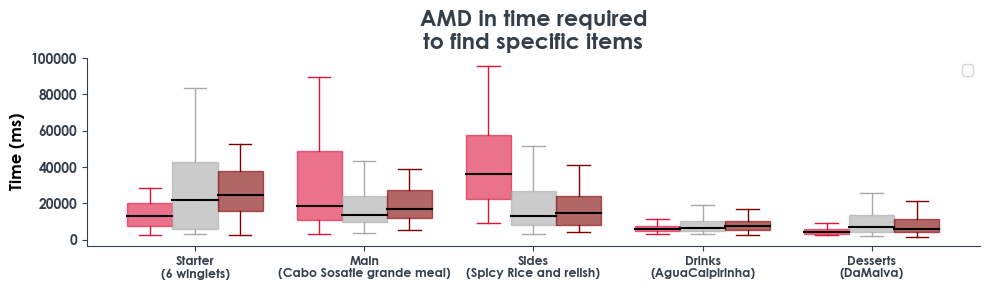

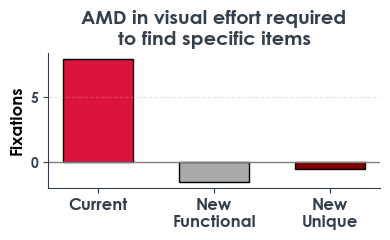

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


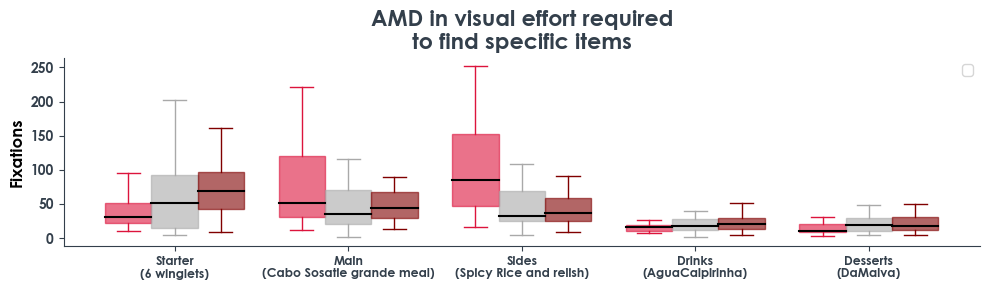

In [56]:
# All items

metrics = ['RT','FixationCount']
y_labels={'RT':'Time (ms)',
          'FixationCount':'Fixations'}
titles = {'RT':'AMD in time required\nto find specific items',
          'FixationCount':'AMD in visual effort required\nto find specific items'}

analysis_periods = {'sns_findSpecific_Item1':'Starter\n(6 winglets)',
                    'sns_findSpecific_Item2':'Main\n(Cabo Sosatie grande meal)',
                    'sns_findSpecific_Item3':'Sides\n(Spicy Rice and relish)',
                    'sns_findSpecific_Item4':'Drinks\n(AguaCaipirinha)',
                    'sns_findSpecific_Item5':'Desserts\n(DaMalva)',}

for metric in metrics:

    df_temp = df.copy()

    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_signed_diff(df_temp, 
                    grouping_col="subset", 
                    periods=periods_temp, 
                    y_label=y_labels[metric], 
                    title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])



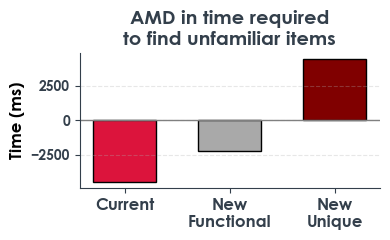

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


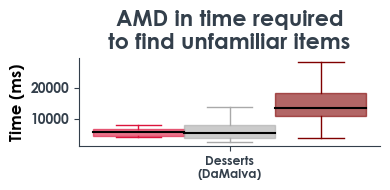

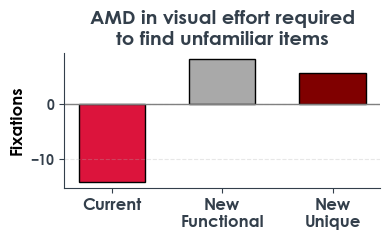

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


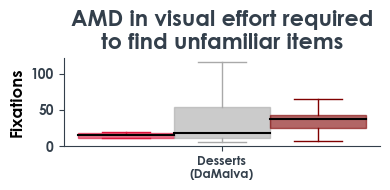

In [74]:
# ND items

metrics = ['RT','FixationCount']
y_labels={'RT':'Time (ms)',
          'FixationCount':'Fixations'}
titles = {'RT':'AMD in time required\nto find unfamiliar items',
          'FixationCount':'AMD in visual effort required\nto find unfamiliar items'}

analysis_periods = {
    # 'sns_findSpecific_Item1':'Starter\n(6 winglets)',
    #                 'sns_findSpecific_Item2':'Main\n(Cabo Sosatie grande meal)',
    #                 'sns_findSpecific_Item3':'Sides\n(Spicy Rice and relish)',
    #                 'sns_findSpecific_Item4':'Drinks\n(AguaCaipirinha)',
                    'sns_findSpecific_Item5':'Desserts\n(DaMalva)',}
for metric in metrics:

    df_temp = df.copy()

    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    for period,_ in periods_temp.items():
        col = '_'.join(period.split('_')[:-1])+'_subjUndiscovered'
        mask = df_temp[col] == 0      # rows you want to suppress
        df_temp.loc[mask, period] = np.nan 

    plot_signed_diff(df_temp, 
                    grouping_col="subset", 
                    periods=periods_temp, 
                    y_label=y_labels[metric], 
                    title = titles[metric])
    plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])



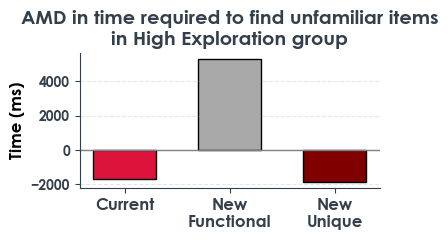

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


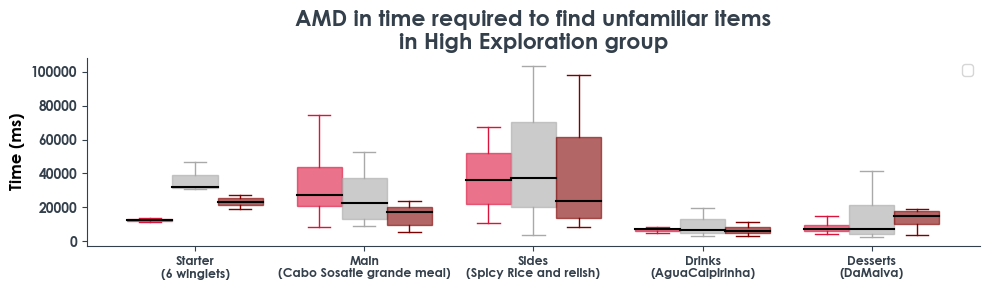

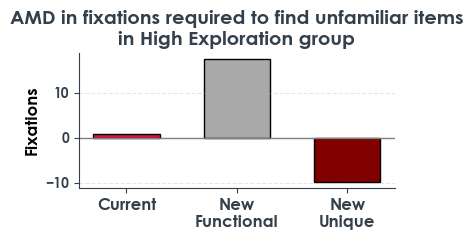

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


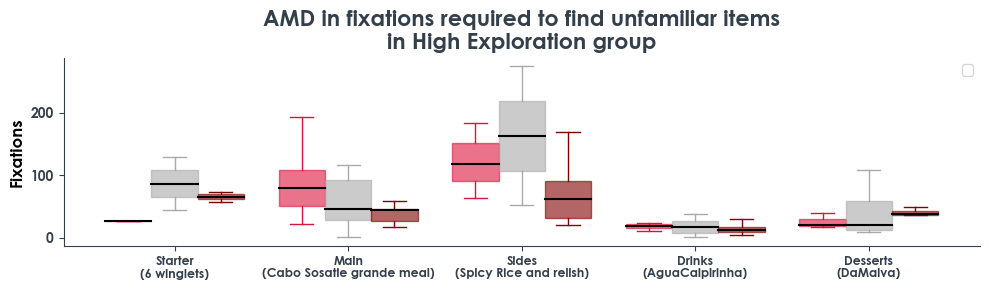

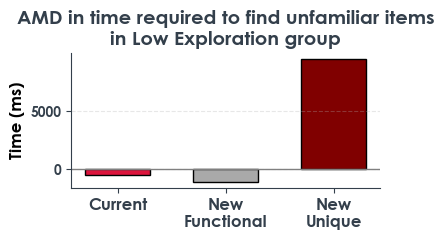

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


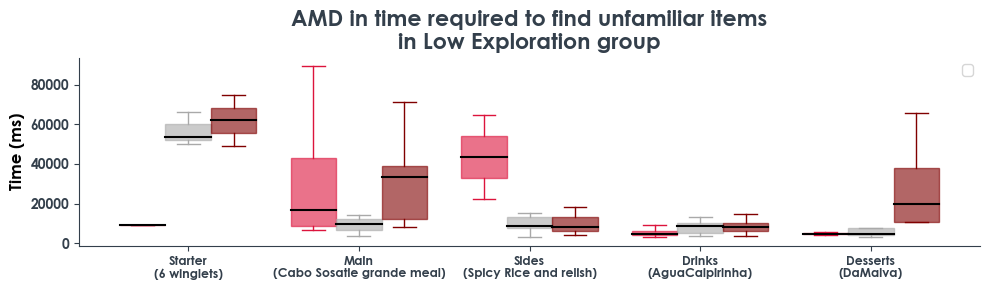

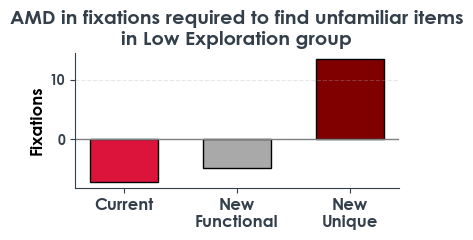

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


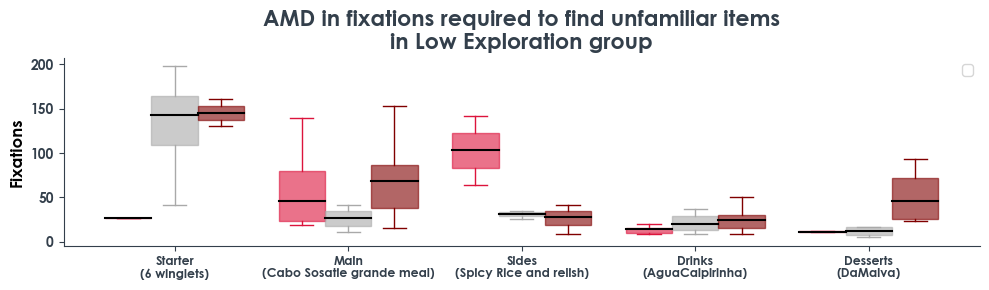

In [40]:
# ND items split

metrics = ['RT','FixationCount']
y_labels={'RT':'Time (ms)',
          'FixationCount':'Fixations'}

analysis_periods = {'sns_findSpecific_Item1':'Starter\n(6 winglets)',
                    'sns_findSpecific_Item2':'Main\n(Cabo Sosatie grande meal)',
                    'sns_findSpecific_Item3':'Sides\n(Spicy Rice and relish)',
                    'sns_findSpecific_Item4':'Drinks\n(AguaCaipirinha)',
                    'sns_findSpecific_Item5':'Desserts\n(DaMalva)',}

df_temp = df.copy()

for split, df_split in df_temp.groupby('split'):
    for metric in metrics:

        titles = {'RT':f'AMD in time required to find unfamiliar items\nin {split} group',
          'FixationCount':f'AMD in fixations required to find unfamiliar items\nin {split} group'}

        periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

        for period,_ in periods_temp.items():
            col = '_'.join(period.split('_')[:-1])+'_subjUndiscovered'
            mask = df_split[col] == 0      # rows you want to suppress
            df_split.loc[mask, period] = np.nan 

        plot_signed_diff(df_split, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])
        plot_repeated_measures(df_split, 
                            grouping_col="subset", 
                            periods=periods_temp, 
                            y_label=y_labels[metric], 
                            title = titles[metric])

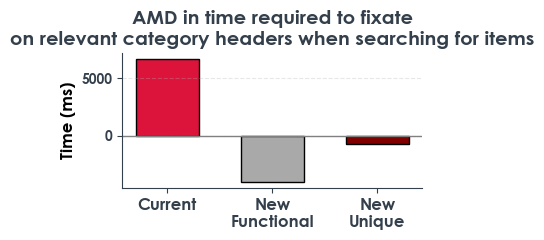

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


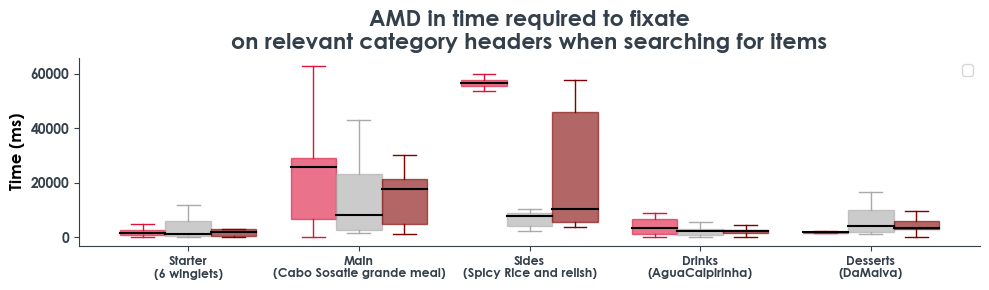

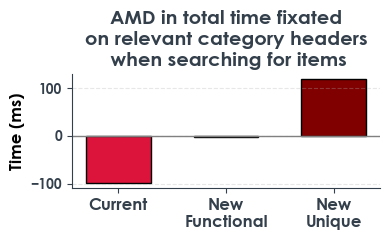

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


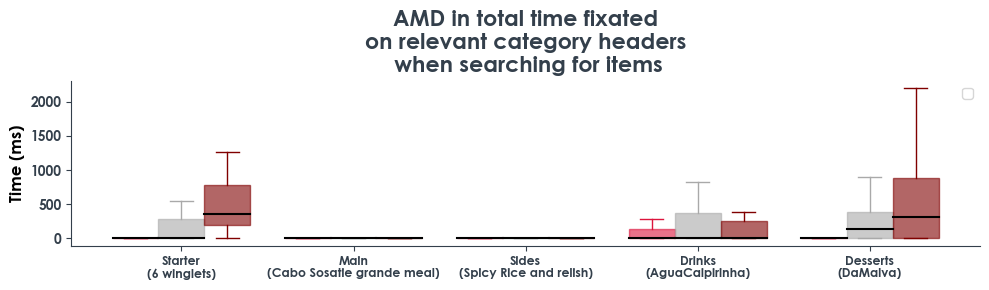

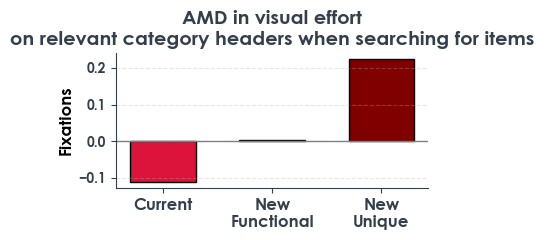

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


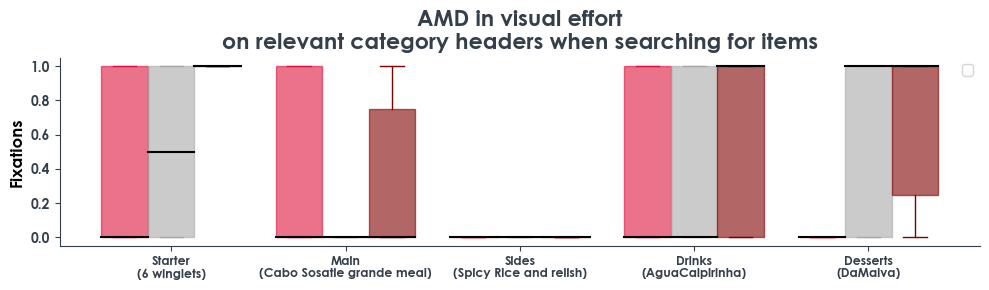

In [66]:
# Headers

relevant_headers = {1:{'Item1':'00',
                       'Item2':'00',
                       'Item3':'03',
                       'Item4':'10',
                       'Item5':'15'},
                    2:{'Item1':'16',
                       'Item2':'20',
                       'Item3':'03',
                       'Item4':'10',
                       'Item5':'28'},
                    3:{'Item1':'29',
                       'Item2':'20',
                       'Item3':'32',
                       'Item4':'10',
                       'Item5':'28'}
}

metrics = ['TTFF','TFD','FixationCount']
y_labels={'TTFF':'Time (ms)',
          'TFD':'Time (ms)',
          'FixationCount':'Fixations'}

titles = {'TTFF':'AMD in time required to fixate\non relevant category headers when searching for items',
          'TFD':'AMD in total time fixated\non relevant category headers\n when searching for items',
          'FixationCount':'AMD in visual effort\non relevant category headers when searching for items'}

analysis_periods = {'iam_findSpecific_Item1_Saliency_Heading':'Item1',
                    'iam_findSpecific_Item2_Saliency_Heading':'Item2',
                    'iam_findSpecific_Item3_Saliency_Heading':'Item3',
                    'iam_findSpecific_Item4_Saliency_Heading':'Item4',
                    'iam_findSpecific_Item5_Saliency_Heading':'Item5',}

df_temp = df.copy()

df_temp.columns = df_temp.columns.str.replace(
    r"Slide(?:22|24|26|28|30)\s*",  # regex: any of those five numbers, followed by spaces
    "",
    regex=True
)



for metric in metrics:
    #for each subset, for each item create a new column that puts in the relevant heading info
   for subset in df_temp.subset.unique():
      for key,value in analysis_periods.items():
         df_temp.loc[df_temp.subset==subset, f'{value}_header']=df_temp.loc[df_temp.subset==subset][f'{key}_{relevant_headers[subset][value]}_{metric}'].values

   periods_temp = {'Item1_header':'Starter\n(6 winglets)',
                   'Item2_header':'Main\n(Cabo Sosatie grande meal)',
                   'Item3_header':'Sides\n(Spicy Rice and relish)',
                   'Item4_header':'Drinks\n(AguaCaipirinha)',
                   'Item5_header':'Desserts\n(DaMalva)',
                   }

   plot_signed_diff(df_temp, 
               grouping_col="subset", 
               periods=periods_temp, 
               y_label=y_labels[metric], 
               title = titles[metric])
   
   plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])
   

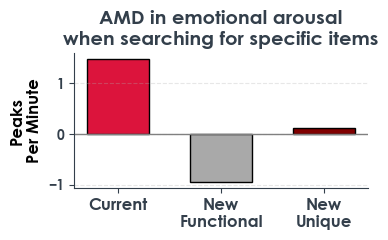

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


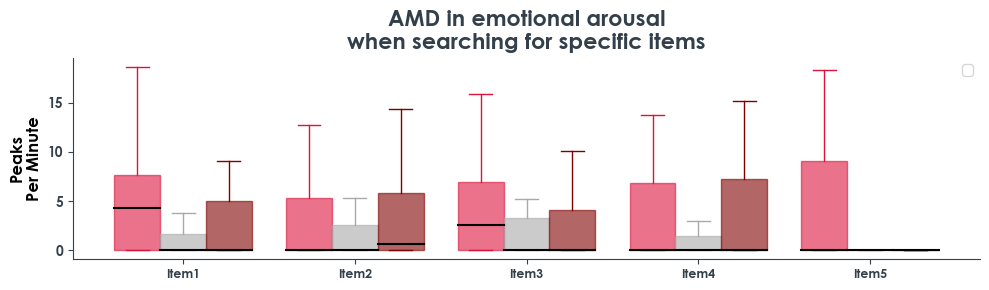

In [57]:
# All items

metrics = ['PPM',]
y_labels={'PPM':'Peaks\nPer Minute',}
titles = {'PPM':'AMD in emotional arousal\nwhen searching for specific items',
          }

analysis_periods = {'gsr_findSpecific_Item1':'Item1',
                    'gsr_findSpecific_Item2':'Item2',
                    'gsr_findSpecific_Item3':'Item3',
                    'gsr_findSpecific_Item4':'Item4',
                    'gsr_findSpecific_Item5':'Item5',}

for metric in metrics:

    df_temp = df.copy()

    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_signed_diff(df_temp, 
                    grouping_col="subset", 
                    periods=periods_temp, 
                    y_label=y_labels[metric], 
                    title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])



# Find Anything

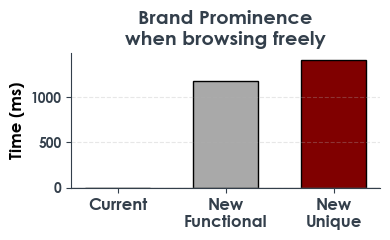

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


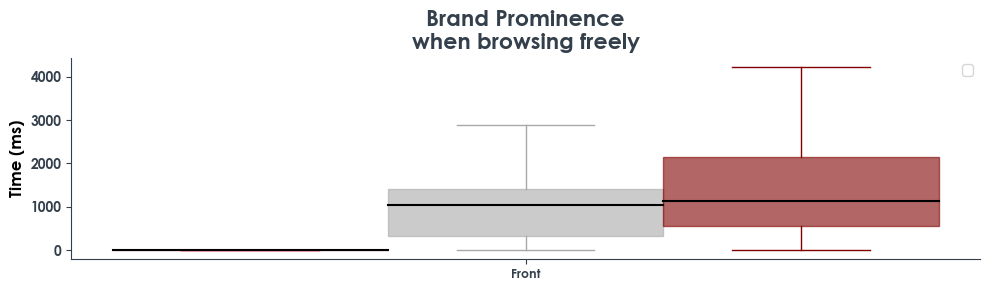

In [61]:
# Brand Prominence

metrics = ['TFD',]
y_labels={'TFD':'Time (ms)',}
titles = {'TFD':'Brand Prominence\nwhen browsing freely',
          }

analysis_periods = {'iam_findAnything_FrontPage_BrandProminence':'Front',}

for metric in metrics:

    df_temp = df.copy()

    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_mean(df_temp, 
                    grouping_col="subset", 
                    periods=periods_temp, 
                    y_label=y_labels[metric], 
                    title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])



C:\Users\ashra\AppData\Local\Temp\ipykernel_33592\4232818737.py:159: RuntimeWarning: Mean of empty slice
  pop_mean = np.nanmean(pop_vals)


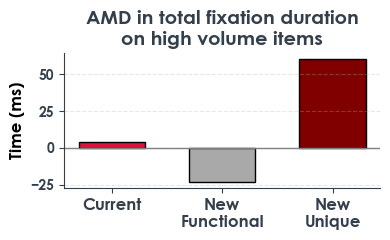

⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_HighGP_1/4 Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_HighGP_1/2 Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_HighGP_Full Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_HighGP_Bowls and Salads_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_HighGP_Sides_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_HighGP_1/4 Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_HighGP_1/2 Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_HighGP_Full Chicken_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_HighGP_Bowls and Salads_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_HighGP_Sides_TFD'
⚠️  empty after filtering → group 2, period 'iam_standard_Stim3_HighGP_1/4 Chicken_TFD'
⚠️  empty after filtering → grou

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


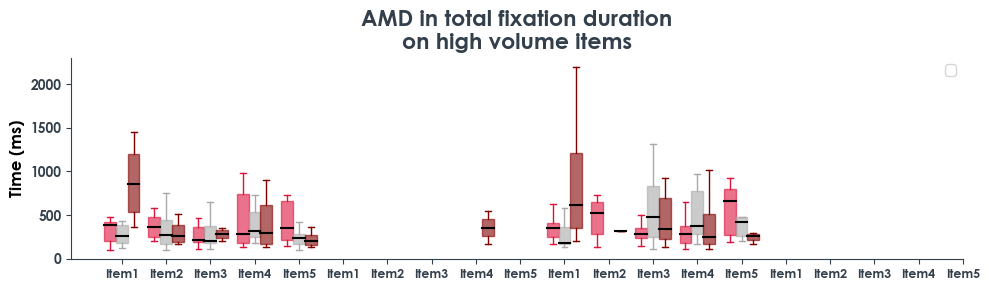

In [62]:
# High GP

metrics = ['TFD',]
y_labels={
          'TFD':'Time (ms)',
          }

titles = {
          'TFD':'AMD in total fixation duration\non high volume items',
}

analysis_periods = {'iam_standard_Stim2_HighGP_1/4 Chicken':'Item1',
                    'iam_standard_Stim2_HighGP_1/2 Chicken':'Item2',
                    'iam_standard_Stim2_HighGP_Full Chicken':'Item3',
                    'iam_standard_Stim2_HighGP_Bowls and Salads':'Item4',
                    'iam_standard_Stim2_HighGP_Sides':'Item5',
                    'iam_standard_Stim3_HighGP_1/4 Chicken':'Item1',
                    'iam_standard_Stim3_HighGP_1/2 Chicken':'Item2',
                    'iam_standard_Stim3_HighGP_Full Chicken':'Item3',
                    'iam_standard_Stim3_HighGP_Bowls and Salads':'Item4',
                    'iam_standard_Stim3_HighGP_Sides':'Item5',
                    'iam_standard_Stim5_HighGP_1/4 Chicken':'Item1',
                    'iam_standard_Stim5_HighGP_1/2 Chicken':'Item2',
                    'iam_standard_Stim5_HighGP_Full Chicken':'Item3',
                    'iam_standard_Stim5_HighGP_Bowls and Salads':'Item4',
                    'iam_standard_Stim5_HighGP_Sides':'Item5',
                    'iam_standard_Stim6_HighGP_1/4 Chicken':'Item1',
                    'iam_standard_Stim6_HighGP_1/2 Chicken':'Item2',
                    'iam_standard_Stim6_HighGP_Full Chicken':'Item3',
                    'iam_standard_Stim6_HighGP_Bowls and Salads':'Item4',
                    'iam_standard_Stim6_HighGP_Sides':'Item5',
}

df_temp = df.copy()

df_temp.columns = df_temp.columns.str.replace(
    r"Slide(?:39|48|42|51)\s*",  # regex: any of those five numbers, followed by spaces
    "",
    regex=True
)


for metric in metrics:
    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_signed_diff(df_temp, 
                grouping_col="subset", 
                periods=periods_temp, 
                y_label=y_labels[metric], 
                title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                grouping_col="subset", 
                periods=periods_temp, 
                y_label=y_labels[metric], 
                title = titles[metric])

C:\Users\ashra\AppData\Local\Temp\ipykernel_33592\1249843511.py:160: RuntimeWarning: Mean of empty slice
  pop_mean = np.nanmean(pop_vals)


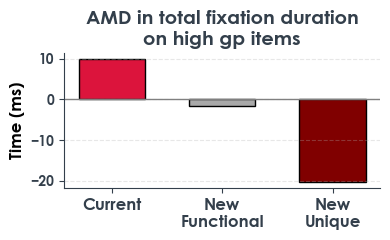

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


⚠️  empty after filtering → group 1, period 'iam_standard_Stim2_NewGP_Strips Veg and Rice_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_NewGP_Garlic/Nandos Roll_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_NewGP_Strips and Rice_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_NewGP_All-in-one bowl_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_NewGP_Avo and Halloumi bowl_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim3_NewGP_Strips Veg and Rice_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim5_NewGP_Strips Veg and Rice_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_NewGP_Garlic/Nandos Roll_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_NewGP_Strips and Rice_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_NewGP_All-in-one bowl_TFD'
⚠️  empty after filtering → group 1, period 'iam_standard_Stim6_Ne

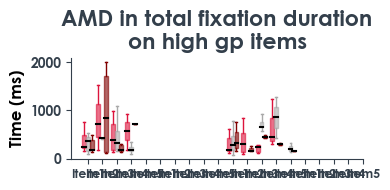

In [77]:
# High GP New

metrics = ['TFD',]
y_labels={
          'TFD':'Time (ms)',
          }

titles = {
          'TFD':'AMD in total fixation duration\non high gp items',
}

2,3,5,6

analysis_periods = {'iam_standard_Stim2_NewGP_Garlic/Nandos Roll':'Item1',
                    'iam_standard_Stim2_NewGP_Strips and Rice':'Item2',
                    'iam_standard_Stim2_NewGP_All-in-one bowl':'Item3',
                    'iam_standard_Stim2_NewGP_Avo and Halloumi bowl':'Item4',
                    'iam_standard_Stim2_NewGP_Strips Veg and Rice':'Item5',
                    'iam_standard_Stim3_NewGP_Garlic/Nandos Roll':'Item1',
                    'iam_standard_Stim3_NewGP_Strips and Rice':'Item2',
                    'iam_standard_Stim3_NewGP_All-in-one bowl':'Item3',
                    'iam_standard_Stim3_NewGP_Avo and Halloumi bowl':'Item4',
                    'iam_standard_Stim3_NewGP_Strips Veg and Rice':'Item5',
                    'iam_standard_Stim5_NewGP_Garlic/Nandos Roll':'Item1',
                    'iam_standard_Stim5_NewGP_Strips and Rice':'Item2',
                    'iam_standard_Stim5_NewGP_All-in-one bowl':'Item3',
                    'iam_standard_Stim5_NewGP_Avo and Halloumi bowl':'Item4',
                    'iam_standard_Stim5_NewGP_Strips Veg and Rice':'Item5',
                    'iam_standard_Stim6_NewGP_Garlic/Nandos Roll':'Item1',
                    'iam_standard_Stim6_NewGP_Strips and Rice':'Item2',
                    'iam_standard_Stim6_NewGP_All-in-one bowl':'Item3',
                    'iam_standard_Stim6_NewGP_Avo and Halloumi bowl':'Item4',
                    'iam_standard_Stim6_NewGP_Strips Veg and Rice':'Item5',
                    
}

df_temp = df.copy()

df_temp.columns = df_temp.columns.str.replace(
    r"Slide(?:39|48|42|51)\s*",  # regex: any of those five numbers, followed by spaces
    "",
    regex=True
)


for metric in metrics:
    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_signed_diff(df_temp, 
                grouping_col="subset", 
                periods=periods_temp, 
                y_label=y_labels[metric], 
                title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                grouping_col="subset", 
                periods=periods_temp, 
                y_label=y_labels[metric], 
                title = titles[metric])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


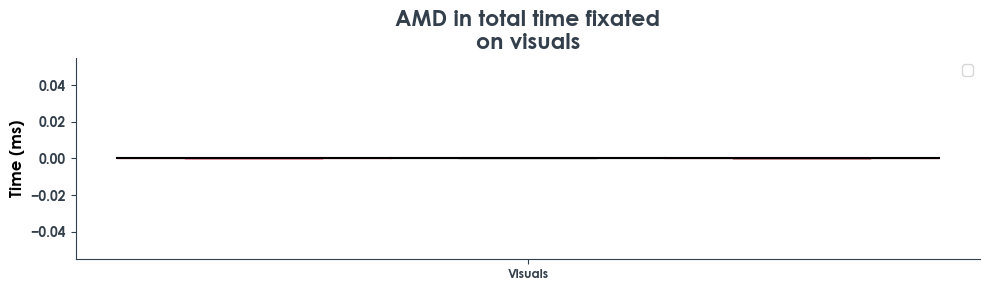

In [63]:
# Key visuals

metrics = ['TFD',]
y_labels={
          'TFD':'Time (ms)',
          }

titles = {
          'TFD':'AMD in total time fixated\non visuals',
}


analysis_periods = {'_'.join(c.split('_')[:-1]):c for c in df.columns if ('iam_findAnything' in c) & ('Visual' in c) & ('Saliency' in c)
}

df_temp = df.copy()

df_temp['Visuals'] = df_temp[analysis_periods.values()].sum(axis=1)


for metric in metrics:
    periods_temp = {'Visuals':'Visuals'}

    plot_repeated_measures(df_temp, 
                grouping_col="subset", 
                periods=periods_temp, 
                y_label=y_labels[metric], 
                title = titles[metric])

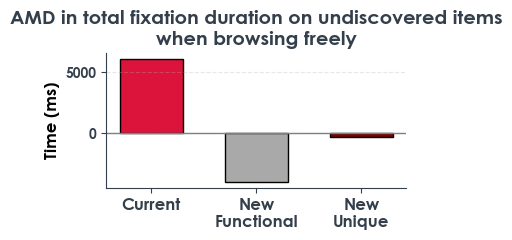

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


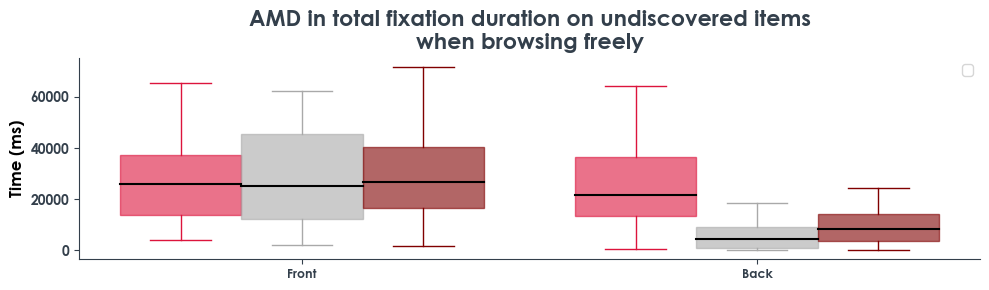

In [64]:
# Undiscovered

metrics = ['TFD',]
y_labels={'TFD':'Time (ms)',}
titles = {'TFD':'AMD in total fixation duration on undiscovered items\nwhen browsing freely',
          }

analysis_periods = {'iam_findAnything_FrontPage_Undiscovered':'Front',
                    'iam_findAnything_BackPage_Undiscovered':'Back',}

for metric in metrics:

    df_temp = df.copy()

    periods_temp = {f'{key}_{metric}':value for key,value in analysis_periods.items()}

    plot_signed_diff(df_temp, 
                    grouping_col="subset", 
                    periods=periods_temp, 
                    y_label=y_labels[metric], 
                    title = titles[metric])
    
    plot_repeated_measures(df_temp, 
                        grouping_col="subset", 
                        periods=periods_temp, 
                        y_label=y_labels[metric], 
                        title = titles[metric])

# Saliency

In [47]:
df_et = pd.read_csv('infiles/df_et.csv')
df_et = pd.merge(df_et,df[['respondent','split']],on='respondent')
print(df_et.columns)

Index(['Unnamed: 0', 'subset_old', 'Respondent Name', 'AOI', 'Stim',
       'FixationCount', 'FFD', 'TTFF', 'TFD', 'Click', 'resp_id_old',
       'respondent', 'subset', 'survey_immediate_start', 'split'],
      dtype='object')


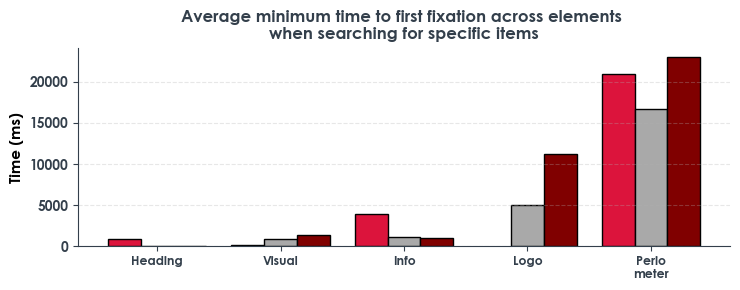

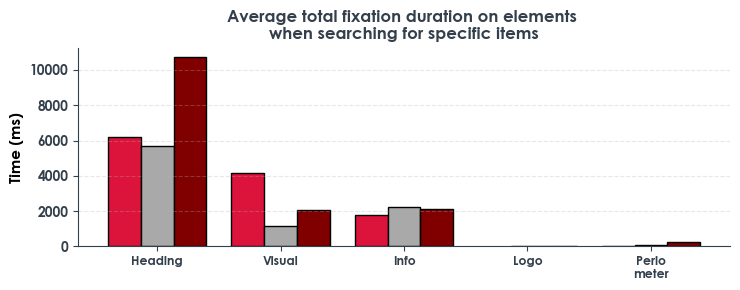

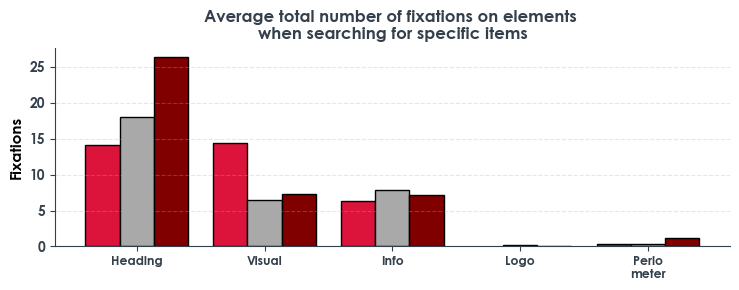

In [65]:
# Specific per menu multiple
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Item')]
df_temp = df_temp.loc[~df_temp.AOI.str.contains('Item')]
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)
df_temp['Element'] = df_temp['AOI'].apply(lambda x:x.split('_')[0])
df_temp["Element"] = df_temp["Element"].mask(
    df_temp["Element"].str.contains("Info", na=False),
    "Info"
)

metrics = ['TTFF','TFD','FixationCount']
y_labels={'TTFF':'Time (ms)',
          'TFD':'Time (ms)',
          'FixationCount':'Fixations'}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item
for metric in metrics:
    titles = {'TTFF':f'Average minimum time to first fixation across elements \nwhen searching for specific items',
            'TFD':f'Average total fixation duration on elements \nwhen searching for specific items',
            'FixationCount':f'Average total number of fixations on elements \nwhen searching for specific items'}
    
    periods_temp = {'Heading':'Heading',
        'Visual':'Visual',
        'Info':'Info',
        'Logo':'Logo',
        'Perio\nmeter':'Perio\nmeter',  
        }
    
    df_temp["Element"] = df_temp["Element"].replace('Periometer','Perio\nmeter')
    for period in periods_temp:
            mask = df_temp["Element"].str.contains(period, na=False)
            df_temp[period] = df_temp[metric].where(mask)

    plot_clustered_aoi(df_temp, 
        grouping_col="Element",
        second_grouping_col='subset' ,
        metric=metric,
        periods=periods_temp, 
        y_label=y_labels[metric], 
        title = titles[metric],
        colors=color_palette)
                

# Start with a total (total for each menu)
# go on to speciifc AOI headers

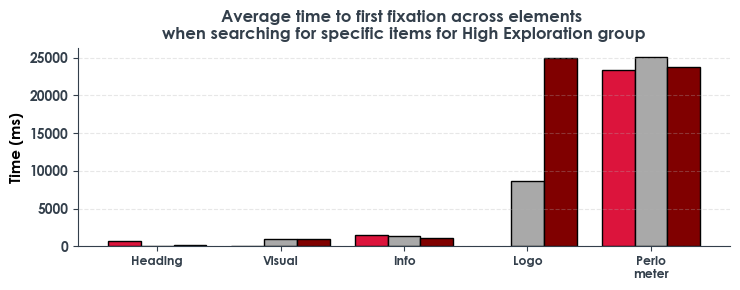

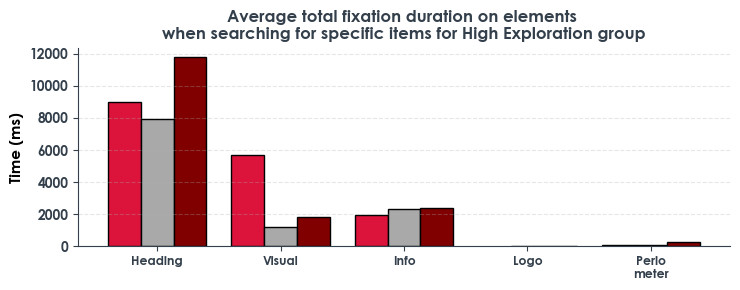

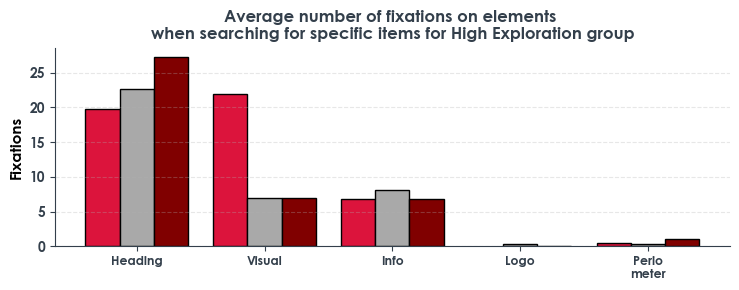

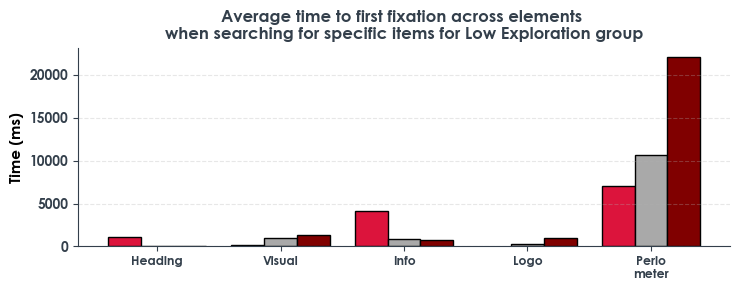

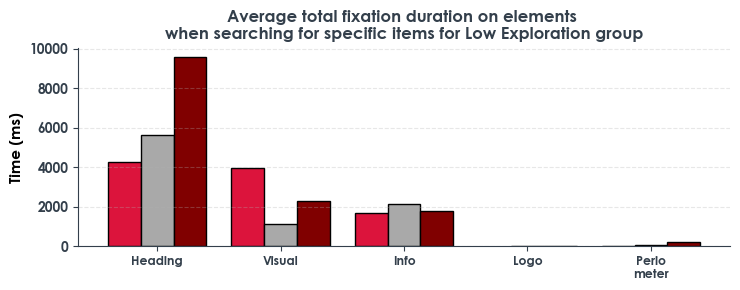

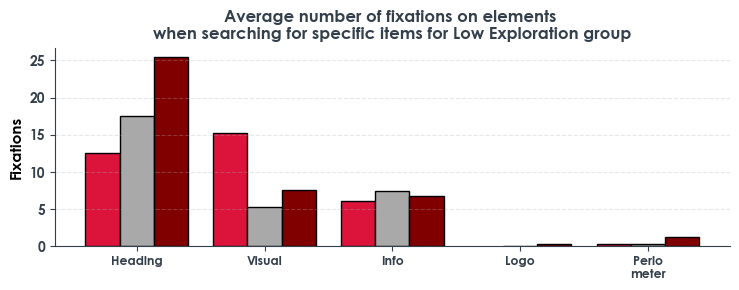

In [49]:
# Specific per menu multiple split
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Item')]
df_temp = df_temp.loc[~df_temp.AOI.str.contains('Item')]
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)
df_temp['Element'] = df_temp['AOI'].apply(lambda x:x.split('_')[0])
df_temp["Element"] = df_temp["Element"].mask(
    df_temp["Element"].str.contains("Info", na=False),
    "Info"
)

metrics = ['TTFF','TFD','FixationCount']
y_labels={'TTFF':'Time (ms)',
          'TFD':'Time (ms)',
          'FixationCount':'Fixations'}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item
for split,df_split in df_temp.groupby('split'):
    for metric in metrics:
        titles = {'TTFF':f'Average time to first fixation across elements \nwhen searching for specific items for {split} group',
                'TFD':f'Average total fixation duration on elements \nwhen searching for specific items for {split} group',
                'FixationCount':f'Average number of fixations on elements \nwhen searching for specific items for {split} group'}
        
        periods_temp = {'Heading':'Heading',
            'Visual':'Visual',
            'Info':'Info',
            'Logo':'Logo',
            'Perio\nmeter':'Perio\nmeter',  
            }
        
        df_split["Element"] = df_split["Element"].replace('Periometer','Perio\nmeter')
        for period in periods_temp:
                mask = df_split["Element"].str.contains(period, na=False)
                df_split[period] = df_split[metric].where(mask)

        plot_clustered_aoi(df_split, 
            grouping_col="Element",
            metric=metric,
            second_grouping_col='subset' ,
            periods=periods_temp, 
            y_label=y_labels[metric], 
            title = titles[metric],
            colors=color_palette)
                

# Start with a total (total for each menu)
# go on to speciifc AOI headers

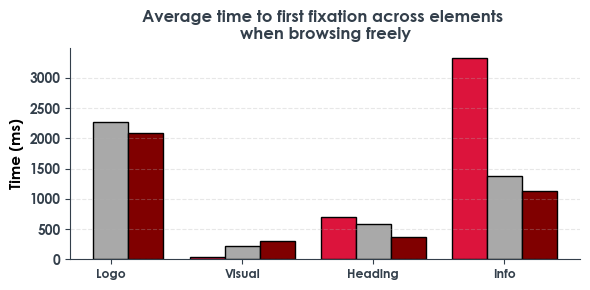

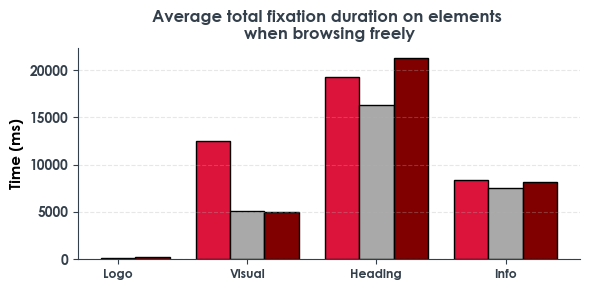

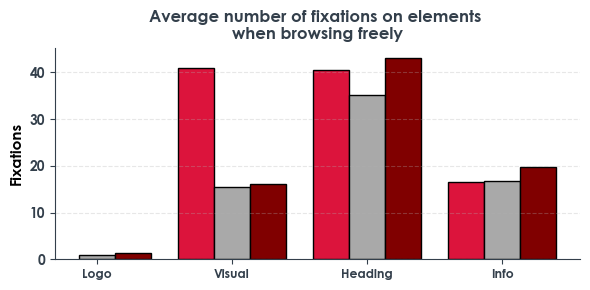

In [68]:
# Anything per menu multiple
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[~df_temp.AOI.str.contains('Item')]
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)
df_temp['Element'] = df_temp['AOI'].apply(lambda x:x.split('_')[0])
df_temp["Element"] = df_temp["Element"].mask(
    df_temp["Element"].str.contains("Info", na=False),
    "Info"
)

metrics = ['TTFF','TFD','FixationCount']
y_labels={'TTFF':'Time (ms)',
          'TFD':'Time (ms)',
          'FixationCount':'Fixations'}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item
for metric in metrics:
    titles = {'TTFF':f'Average time to first fixation across elements \nwhen browsing freely',
            'TFD':f'Average total fixation duration on elements \nwhen browsing freely',
            'FixationCount':f'Average number of fixations on elements \nwhen browsing freely'}
    
    periods_temp = {'Logo':'Logo',
                    'Visual':'Visual',
                    'Heading':'Heading',
                    #'Perio\nmeter':'Perio\nmeter', 
                    'Info':'Info'
        }
    
    df_temp["Element"] = df_temp["Element"].replace('Periometer','Perio\nmeter')
    for period in periods_temp:
            mask = df_temp["Element"].str.contains(period, na=False)
            df_temp[period] = df_temp[metric].where(mask)

    plot_clustered_aoi(df_temp, 
        grouping_col="Element",
        metric=metric,
        second_grouping_col='subset' ,
        periods=periods_temp, 
        y_label=y_labels[metric], 
        title = titles[metric],
        colors=color_palette)
                

# Start with a total (total for each menu)
# go on to speciifc AOI headers

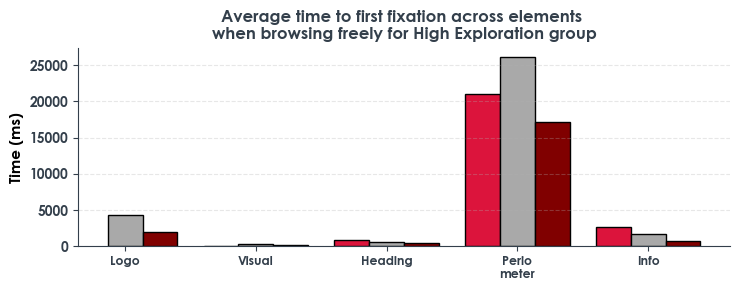

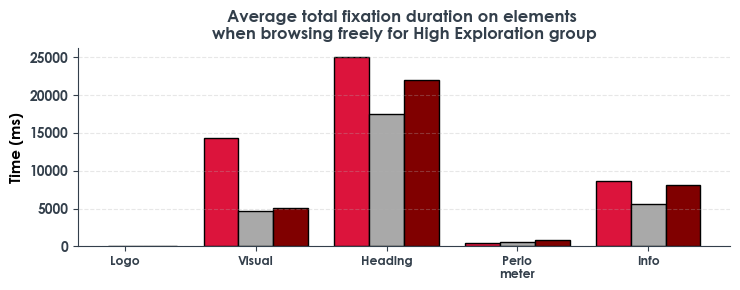

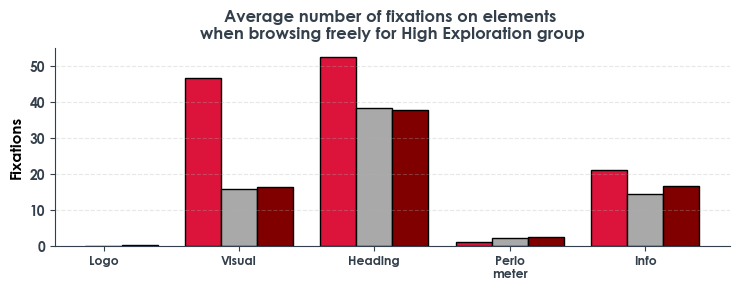

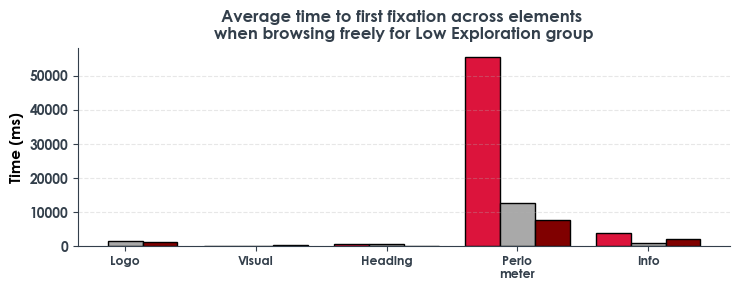

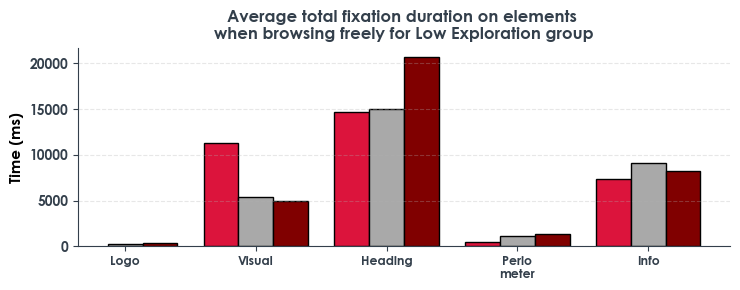

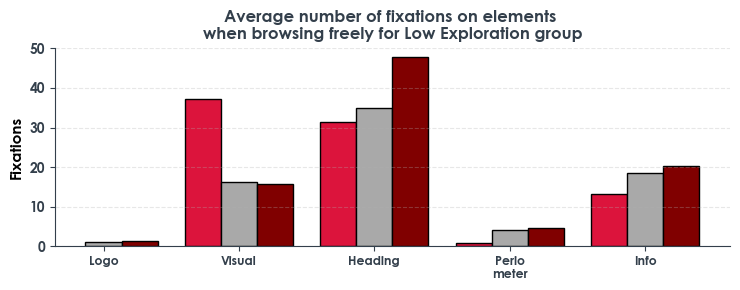

In [51]:
# Anything per menu multiple split
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[~df_temp.AOI.str.contains('Item')]
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)
df_temp['Element'] = df_temp['AOI'].apply(lambda x:x.split('_')[0])
df_temp["Element"] = df_temp["Element"].mask(
    df_temp["Element"].str.contains("Info", na=False),
    "Info"
)

metrics = ['TTFF','TFD','FixationCount']
y_labels={'TTFF':'Time (ms)',
          'TFD':'Time (ms)',
          'FixationCount':'Fixations'}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item

for split,df_split in df_temp.groupby('split'):
    for metric in metrics:
        titles = {'TTFF':f'Average time to first fixation across elements \nwhen browsing freely for {split} group',
                'TFD':f'Average total fixation duration on elements \nwhen browsing freely for {split} group',
                'FixationCount':f'Average number of fixations on elements \nwhen browsing freely for {split} group'}
        
        periods_temp = {'Logo':'Logo',
                        'Visual':'Visual',
                        'Heading':'Heading',
                        'Perio\nmeter':'Perio\nmeter', 
                        'Info':'Info'
            }
        
        df_split["Element"] = df_split["Element"].replace('Periometer','Perio\nmeter')
        for period in periods_temp:
                mask = df_split["Element"].str.contains(period, na=False)
                df_split[period] = df_split[metric].where(mask)

        plot_clustered_aoi(df_split, 
            grouping_col="Element",
            second_grouping_col='subset' ,
            metric=metric,
            periods=periods_temp, 
            y_label=y_labels[metric], 
            title = titles[metric],
            colors=color_palette)
                

# Start with a total (total for each menu)
# go on to speciifc AOI headers

['Slide8 Current1' 'Slide13 Current2' 'Slide8 NewF1' 'Slide13 NewF2'
 'Slide8 NewU1' 'Slide13 NewU2']
10.9438202247191


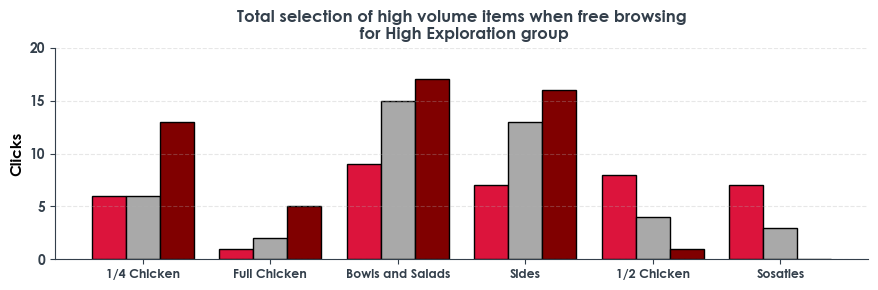

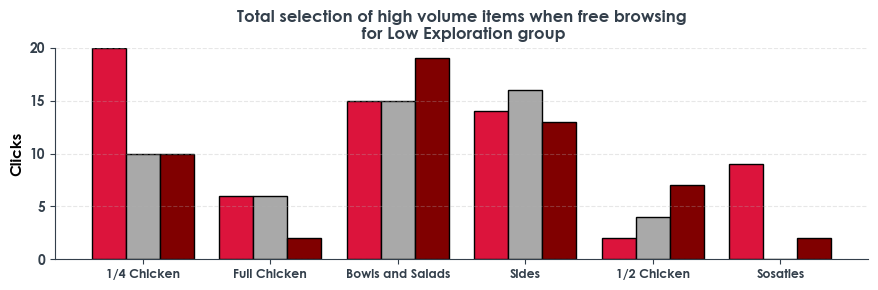

In [52]:
# Anything per menu clicks multiple
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Item')]
df_temp['ID'] = df_temp['AOI'].apply(lambda x:int(x.split('_')[1]))

print(df_temp.Stim.unique())
print(df_temp.groupby('respondent').sum()['Click'].mean())

metrics = ['Click',]
y_labels={'Click':'Clicks',}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item


high_gp = {'1/4 Chicken':[2,3,4,5],
           'Full Chicken':[36,79,80,81,82],
           'Bowls and Salads':[57,11,39,69,43,42,78,32],
           'Sides':[7,83,20,29,54,60,61,35,51,53,45],
           '1/2 Chicken':[0,1],
           'Sosaties':[15,16,74,17,98]
        }


for split,df_split in df_temp.groupby('split'):
        for metric in metrics:
                titles = {'Click':f'Total selection of high volume items when free browsing\n for {split} group',}

                for category, ids in high_gp.items():
                        mask = df_split["ID"].isin(ids)
                        df_split.loc[mask, 'HighGP'] = category
                        df_split[category] = df_split[metric].where(mask)
                df_split= df_split.dropna(subset=['HighGP',])
                        
                high_gp_labels = {'1/4 Chicken':'1/4 Chicken',
                        'Full Chicken':'Full Chicken',
                        'Bowls and Salads':'Bowls and Salads',
                        'Sides':'Sides',
                        '1/2 Chicken':'1/2 Chicken',
                        'Sosaties':'Sosaties'
                        }
                plot_clustered_aoi(df_split, 
                        grouping_col="HighGP",
                        metric=metric,
                        second_grouping_col='subset' ,
                        periods=high_gp_labels, 
                        y_label=y_labels[metric], 
                        title = titles[metric],
                        colors=color_palette,
                        y_lim = (0,20))
                

['Slide8 Current1' 'Slide13 Current2' 'Slide8 NewF1' 'Slide13 NewF2'
 'Slide8 NewU1' 'Slide13 NewU2']
10.9438202247191


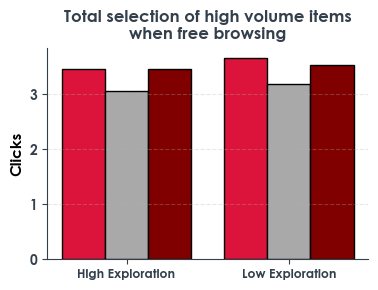

In [118]:
# Anything per menu clicks multiple
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Item')]
df_temp['ID'] = df_temp['AOI'].apply(lambda x:int(x.split('_')[1]))

print(df_temp.Stim.unique())
print(df_temp.groupby('respondent').sum()['Click'].mean())

metrics = ['Click',]
y_labels={'Click':'Clicks',}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item


high_gp = {'1/4 Chicken':[2,3,4,5],
           'Full Chicken':[36,79,80,81,82],
           'Bowls and Salads':[57,11,39,69,43,42,78,32],
           'Sides':[7,83,20,29,54,60,61,35,51,53,45],
           '1/2 Chicken':[0,1],
           'Sosaties':[15,16,74,17,98]
        }

flattened = [item for sublist in high_gp.values() for item in sublist]

for metric in metrics:
        titles = {'Click':f'Total selection of high volume items\nwhen free browsing',}

        for split in df_temp.split.unique():
                mask = df_temp["ID"].isin(flattened) & (df_temp.split==split)
                df_temp[split] = df_temp[metric].where(mask)
        
        df_temp = df_temp.dropna(subset = ['High Exploration','Low Exploration'], how='all')

        high_gp_labels = {'High Exploration':'High Exploration',
                          'Low Exploration':'Low Exploration'
                }
        
        plot_clustered_aoi(df_temp, 
                grouping_col='split',
                metric=metric,
                second_grouping_col='subset' ,
                periods=high_gp_labels, 
                y_label=y_labels[metric], 
                title = titles[metric],
                colors=color_palette,)
            

['Slide8 Current1' 'Slide13 Current2' 'Slide8 NewF1' 'Slide13 NewF2'
 'Slide8 NewU1' 'Slide13 NewU2']
10.9438202247191


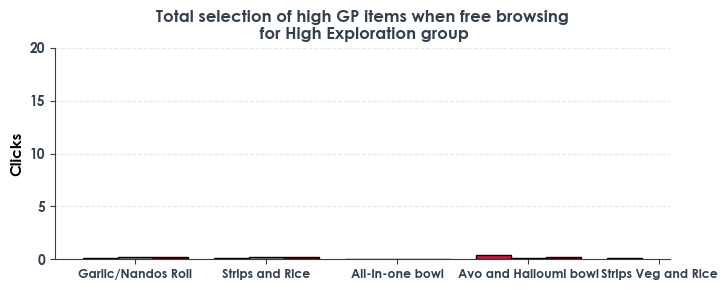

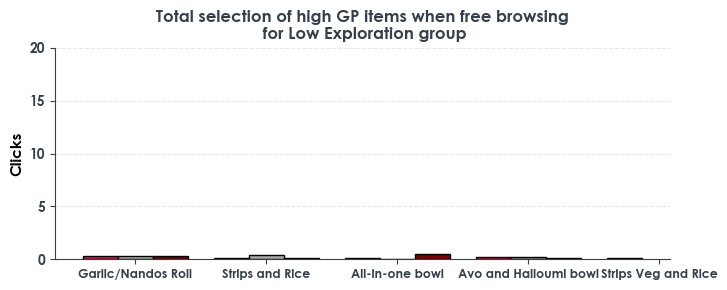

In [117]:
# Anything per menu clicks multiple NEW GP
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Item')]
df_temp['ID'] = df_temp['AOI'].apply(lambda x:int(x.split('_')[1]))

print(df_temp.Stim.unique())
print(df_temp.groupby('respondent').sum()['Click'].mean())

metrics = ['Click',]
y_labels={'Click':'Clicks',}


subset_titles = {1:'Current',
                 2:'New Functional',
                 3:'New Unique'}
# for each visual type, for each item


high_gp = {'Garlic/Nandos Roll':[12,37,114,],
           'Strips and Rice':[22],
           'All-in-one bowl':[57],
           'Avo and Halloumi bowl':[11],
           'Strips Veg and Rice':[78]
        }


for split,df_split in df_temp.groupby('split'):
        for metric in metrics:
                titles = {'Click':f'Total selection of high GP items when free browsing\n for {split} group',}

                for category, ids in high_gp.items():
                        mask = df_split["ID"].isin(ids)
                        df_split.loc[mask, 'HighGP'] = category
                        df_split[category] = df_split[metric].where(mask)
                df_split= df_split.dropna(subset=['HighGP',])
                        
                high_gp_labels = {i:i for i,_ in high_gp.items()}
                
                plot_clustered_aoi(df_split, 
                        grouping_col="HighGP",
                        metric=metric,
                        second_grouping_col='subset' ,
                        periods=high_gp_labels, 
                        y_label=y_labels[metric], 
                        title = titles[metric],
                        colors=color_palette,
                        y_lim = (0,20))
                

['Slide8 Current1' 'Slide13 Current2' 'Slide8 NewF1' 'Slide13 NewF2'
 'Slide8 NewU1' 'Slide13 NewU2']
10.9438202247191


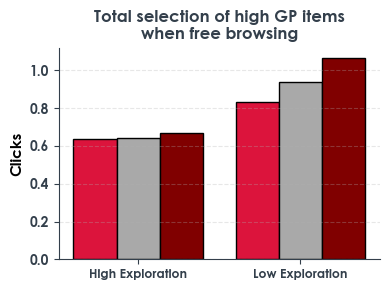

In [115]:
# Anything per menu clicks New GP
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Item')]
df_temp['ID'] = df_temp['AOI'].apply(lambda x:int(x.split('_')[1]))

print(df_temp.Stim.unique())
print(df_temp.groupby('respondent').sum()['Click'].mean())

metrics = ['Click',]
y_labels={'Click':'Clicks',}


high_gp = {'Garlic/Nandos Roll':[12,37,114,],
           'Strips and Rice':[22],
           'All-in-one bowl':[57],
           'Avo and Halloumi bowl':[11],
           'Strips Veg and Rice':[78]
        }
# for each visual type, for each item


flattened = [item for sublist in high_gp.values() for item in sublist]

for metric in metrics:
        titles = {'Click':f'Total selection of high GP items\nwhen free browsing',}

        for split in df_temp.split.unique():
                mask = df_temp["ID"].isin(flattened) & (df_temp.split==split)
                df_temp[split] = df_temp[metric].where(mask)
        
        df_temp = df_temp.dropna(subset = ['High Exploration','Low Exploration'], how='all')

        high_gp_labels = {'High Exploration':'High Exploration',
                          'Low Exploration':'Low Exploration'
                }
        
        plot_clustered_aoi(df_temp, 
                grouping_col='split',
                metric=metric,
                second_grouping_col='subset' ,
                periods=high_gp_labels, 
                y_label=y_labels[metric], 
                title = titles[metric],
                colors=color_palette,)

['Slide8 Current1' 'Slide13 Current2' 'Slide8 NewF1' 'Slide13 NewF2'
 'Slide8 NewU1' 'Slide13 NewU2']
10.9438202247191


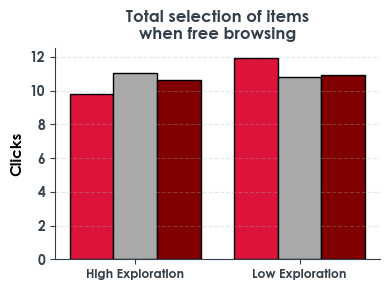

In [116]:
# Anything per menu clicks New GP
# Create a new column for each relevant thing
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Item')]
df_temp['ID'] = df_temp['AOI'].apply(lambda x:int(x.split('_')[1]))

print(df_temp.Stim.unique())
print(df_temp.groupby('respondent').sum()['Click'].mean())

metrics = ['Click',]
y_labels={'Click':'Clicks',}

# for each visual type, for each item


flattened = [item for sublist in high_gp.values() for item in sublist]

for metric in metrics:
        titles = {'Click':f'Total selection of items\nwhen free browsing',}

        for split in df_temp.split.unique():
                mask = (df_temp.split==split)
                df_temp[split] = df_temp[metric].where(mask)
        
        df_temp = df_temp.dropna(subset = ['High Exploration','Low Exploration'], how='all')

        high_gp_labels = {'High Exploration':'High Exploration',
                          'Low Exploration':'Low Exploration'
                }
        
        plot_clustered_aoi(df_temp, 
                grouping_col='split',
                metric=metric,
                second_grouping_col='subset' ,
                periods=high_gp_labels, 
                y_label=y_labels[metric], 
                title = titles[metric],
                colors=color_palette,)

In [126]:
# Periometer

metrics = ['TFD',]
y_labels={
          'TFD':'Time (ms)',
          }

titles = {
          'TFD':'AMD in total time fixated\non visuals',
}


analysis_periods = {'_'.join(c.split('_')[:-1]):c for c in df.columns if ('iam_findSpecific' in c) & ('Peri' in c) & ('Saliency' in c)
}

df_temp = df.copy()

df_temp['Peri'] = df_temp[analysis_periods.values()].count(axis=1)

print(df_temp[analysis_periods.values()].sum())

def plot_data(
    df,
    grouping_col,
    col: str,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [df.loc[df[grouping_col] == g][col].sum() for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

for metric in metrics:
    periods_temp = {'Visuals':'Visuals'}

    plot_data(df_temp, 
                grouping_col="subset", 
                col = 'Peri', 
                y_label='Count', 
                title = titles[metric])

KeyboardInterrupt: 

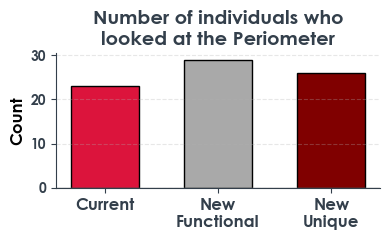

In [130]:
# Peri

df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[df_temp.AOI.str.contains('Periom')]

def plot_data(
    df,
    grouping_col,
    col: str,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [df.loc[df[grouping_col] == g][col].count() for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_data(df_temp, 
            grouping_col="subset", 
            col = 'TFD', 
            y_label='Count', 
            title = 'Number of individuals who\nlooked at the Periometer')

   subset  Behaviour
0       2          8
1       3          7


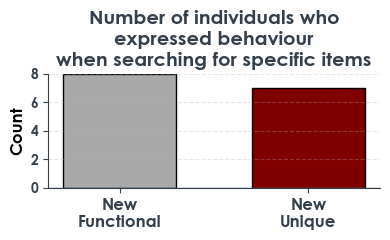

In [160]:
# Heading visual behaviour
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Item')]
df_temp = df_temp.loc[~(df_temp.subset==1)]
df_temp = df_temp.sort_values(by=['respondent','Stim','TTFF'])
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)


# --- 2. Compute “previous AOI” within each respondent–Stim block -------------
df_temp['prev_AOI'] = df_temp.groupby(['respondent', 'Stim'])['AOI'].shift(1)

# --- 3. Flag the transitions you care about ----------------------------------
rules = {
    '3_m':('Heading_30', 'Visual_16'),
    '3_h':('Heading_31', 'Visual_17'),
    '2_m':('Heading_18', 'Visual_16'),
    '2_h':('Heading_08', 'Visual_17'),    
}


df_temp['Behaviour'] = (
                        (df_temp['prev_AOI'].eq(rules['3_m'][0]) & df_temp['AOI'].eq(rules['3_m'][1]))
                        |(df_temp['prev_AOI'].eq(rules['3_h'][0]) & df_temp['AOI'].eq(rules['3_h'][1]))
                        |(df_temp['prev_AOI'].eq(rules['2_m'][0]) & df_temp['AOI'].eq(rules['2_m'][1]))
                        |(df_temp['prev_AOI'].eq(rules['2_h'][0]) & df_temp['AOI'].eq(rules['2_h'][1]))
                        ).astype(int)

# --- 4. Aggregate counts for each respondent–Stim pair -----------------------
summary = (
    df_temp.groupby(['subset'])['Behaviour']
      .sum()
      .reset_index()
)

print(summary)

def plot_data(
    df,
    grouping_col,
    col: str,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [df.loc[df[grouping_col] == g][col].sum() for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(top=8)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_data(df_temp, 
            grouping_col="subset", 
            col = 'Behaviour', 
            y_label='Count', 
            title = 'Number of individuals who\nexpressed behaviour\nwhen searching for specific items')


   subset  Behaviour
0       2          3
1       3          3


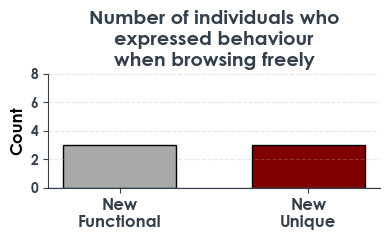

In [159]:
# Heading visual behaviour
df_temp = df_et.copy()
df_temp = df_temp.loc[df_temp.Stim.str.contains('Slide8')
                      | df_temp.Stim.str.contains('Slide13')]
df_temp = df_temp.loc[~(df_temp.subset==1)]
df_temp = df_temp.sort_values(by=['respondent','Stim','TTFF'])
df_temp['AOI'] = df_temp['AOI'].replace('InfoLogo','Logo',regex=True)


# --- 2. Compute “previous AOI” within each respondent–Stim block -------------
df_temp['prev_AOI'] = df_temp.groupby(['respondent', 'Stim'])['AOI'].shift(1)

# --- 3. Flag the transitions you care about ----------------------------------
rules = {
    '3_m':('Heading_30', 'Visual_16'),
    '3_h':('Heading_31', 'Visual_17'),
    '2_m':('Heading_18', 'Visual_16'),
    '2_h':('Heading_08', 'Visual_17'),    
}

df_temp['Behaviour'] = (
                        (df_temp['prev_AOI'].eq(rules['3_m'][0]) & df_temp['AOI'].eq(rules['3_m'][1]))
                        |(df_temp['prev_AOI'].eq(rules['3_h'][0]) & df_temp['AOI'].eq(rules['3_h'][1]))
                        |(df_temp['prev_AOI'].eq(rules['2_m'][0]) & df_temp['AOI'].eq(rules['2_m'][1]))
                        |(df_temp['prev_AOI'].eq(rules['2_h'][0]) & df_temp['AOI'].eq(rules['2_h'][1]))
                        ).astype(int)


# --- 4. Aggregate counts for each respondent–Stim pair -----------------------
summary = (
    df_temp.groupby(['subset'])['Behaviour']
      .sum()
      .reset_index()
)

print(summary)

def plot_data(
    df,
    grouping_col,
    col: str,          # ordered {column_header: pretty_label}
    title="",
    y_label="Mean diff vs. period mean",
):
    """Bar-plot the signed deviation of each group from the period mean.

    • At each period p:
        pop_mean_p  = mean(all groups, after outlier trim)
        diff_{g,p}  = mean(group g, p) − pop_mean_p
    • For each group g: bar height = mean_p( diff_{g,p} )
    """

    groups = sorted(df[grouping_col].dropna().unique())

    # ── plotting ────────────────────────────────────────────────────────────
    x = np.arange(len(groups))
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.bar(
        x,
        [df.loc[df[grouping_col] == g][col].sum() for g in groups],
        color=[color_palette[g] for g in groups],
        edgecolor="black",
        width=0.6,
    )

    ax.axhline(0, color="grey", linewidth=1)  # zero reference
    ax.set_xticks(x)
    ax.set_xticklabels([subset_dict[g] for g in groups], fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(top=8)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_data(df_temp, 
            grouping_col="subset", 
            col = 'Behaviour', 
            y_label='Count', 
            title = 'Number of individuals who\nexpressed behaviour\nwhen browsing freely')
